In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

In [2]:
from sklearn.ensemble import ExtraTreesClassifier

D:\Anaconda\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
train=pd.read_csv('data/train.csv')

In [4]:
test=pd.read_csv('data/test.csv')

In [108]:
features = [c for c in train.columns if c not in ['ID_code', 'target']]

In [107]:
y=train['target']
X = train.drop(['target', 'ID_code'], axis=1)

In [6]:
X_test=test.drop(['ID_code'], axis=1)

In [9]:
y_small=y[:100000]
X_small=X[:100000]

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_small, y_small, test_size=0.1, random_state=42)

## Bayesian Optimization

Use bayesian optimization to accelerate the tuning of hyperparameters, extra tree, random forest, KNN, SVM and logistic regression are optimized with this approach. The stacking and blending of models can be found in `Ensemble stacking` jupyter file.

### Extra trees classifier

In [18]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score

In [23]:

best = 0

def hyperopt_train_test(params):
    clf = ExtraTreesClassifier(**params)
    return cross_val_score(clf, X_small, y_small,scoring='roc_auc', cv=3, n_jobs=-1).mean()

def loss(params):
    global best
    roc = hyperopt_train_test(params)
    if roc > best:
        best = roc
        print ('new best:', best, params)
    return {'loss': -roc, 'status': STATUS_OK}

trials = Trials()


In [18]:
space4et = {
    'max_depth': hp.choice('max_depth', range(1,20)),
    'max_features': hp.choice('max_features', range(1,20)),
    'n_estimators': hp.choice('n_estimators', np.arange(200,2000,50)),
    'criterion': hp.choice('criterion', ["gini", "entropy"]),
    'min_samples_split': hp.choice('min_samples_split', np.arange(10,300,10)),
    'min_samples_leaf': hp.choice('min_samples_leaf', np.arange(2,200,2))
}

In [24]:
best_cv = fmin(loss, space4et, algo=tpe.suggest, max_evals=300, trials=trials)

new best:                                                                                                              
0.8753833455343675                                                                                                     
{'criterion': 'gini', 'max_depth': 12, 'max_features': 5, 'min_samples_leaf': 120, 'min_samples_split': 90, 'n_estimators': 550}
new best:                                                                                                              
0.881036953424576                                                                                                      
{'criterion': 'gini', 'max_depth': 8, 'max_features': 2, 'min_samples_leaf': 192, 'min_samples_split': 110, 'n_estimators': 1550}
new best:                                                                                                              
0.8813784377440751                                                                                                     
{'criterion': 'gini',

0 n_estimators
1 max_depth
2 max_features
3 criterion
4 min_samples_split
5 min_samples_leaf


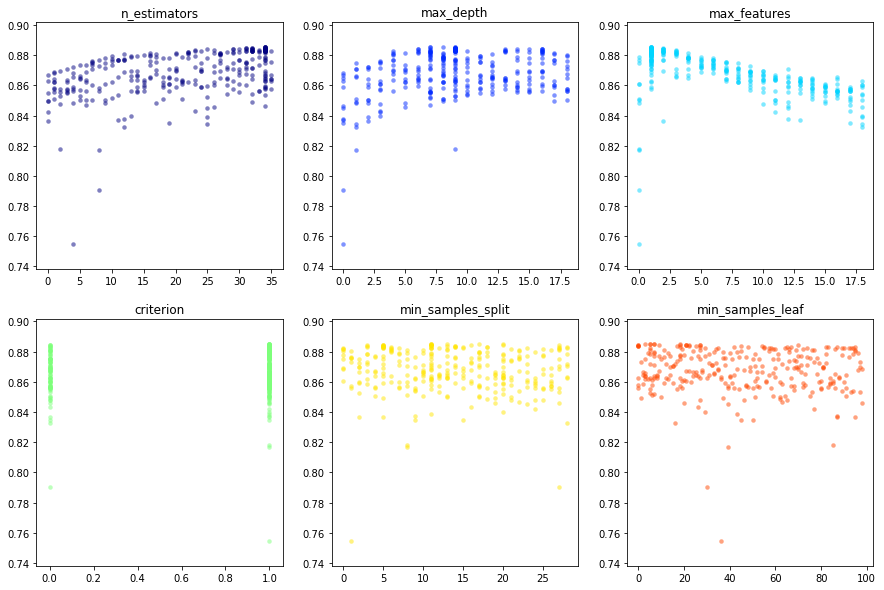

In [38]:
parameters = ['n_estimators', 'max_depth', 'max_features', 'criterion', 'min_samples_split', 'min_samples_leaf']

f, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,10))
cmap = plt.cm.jet

for i, val in enumerate(parameters):
    print (i, val)
    xs = np.array([t['misc']['vals'][val] for t in trials.trials]).ravel()
    ys = [-t['result']['loss'] for t in trials.trials]
    xs, ys = zip(*sorted(zip(xs, ys)))
    ys = np.array(ys)
    axes[i//3,i%3].scatter(xs, ys, s=20, linewidth=0.01, alpha=0.5, c=cmap(float(i)/len(parameters)))
    axes[i//3,i%3].set_title(val)
    #axes[i/3,i%3].set_ylim([0.9,1.0])

### Random forest classifier

In [39]:
from sklearn.ensemble import RandomForestClassifier

In [40]:
best1 = 0

def hyperopt_train_test1(params):
    clf = RandomForestClassifier(**params)
    return cross_val_score(clf, X_small, y_small,scoring='roc_auc', cv=3, n_jobs=-1).mean()

def loss1(params):
    global best1
    roc = hyperopt_train_test1(params)
    if roc > best1:
        best1 = roc
        print ('new best:', best1, params)
    return {'loss': -roc, 'status': STATUS_OK}

trials1 = Trials()


In [42]:
space4rf = {
    'max_depth': hp.choice('max_depth', range(1,20)),
    'max_features': hp.choice('max_features', range(1,15)),
    'n_estimators': hp.choice('n_estimators', np.arange(800,2000,100)),
    'criterion': hp.choice('criterion', ["gini", "entropy"]),
    'min_samples_split': hp.choice('min_samples_split', np.arange(10,300,10)),
    'min_samples_leaf': hp.choice('min_samples_leaf', np.arange(2,200,2)),
    'class_weight': hp.choice('class_weight', [None, "balanced"])
}

In [ ]:
best_cv1 = fmin(loss1, space4rf, algo=tpe.suggest, max_evals=300, trials=trials1)

new best:                                                                                                              
0.8556224908164277                                                                                                     
{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 15, 'max_features': 8, 'min_samples_leaf': 22, 'min_samples_split': 210, 'n_estimators': 800}
new best:                                                                                                              
0.862567005964468                                                                                                      
{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 15, 'max_features': 6, 'min_samples_leaf': 78, 'min_samples_split': 270, 'n_estimators': 1000}
new best:                                                                                                              
0.8687916208101907                                                                   

### KNeighbors Classifier

In [4]:
from sklearn.neighbors import KNeighborsClassifier

In [5]:
def shuffle(x,y,t=2):
    # Shuffle positive samples twice and added to the existing 
    pos_shuffle=[]
    neg_shuffle=[]
    for i in range(t):
        mask=y==1
        x1=x[mask].copy()
        rows=np.arange(x1.shape[0])
        for col in range(x1.shape[1]):
            np.random.seed(1111)
            np.random.shuffle(rows) # shuffle rows in each column
            x1[:,col]=x1[rows][:,col]
        pos_shuffle.append(x1)
    for i in range(t//2):
        mask=y==0
        x1=x[mask].copy()
        rows=np.arange(x1.shape[0])
        for col in range(x1.shape[1]):
            np.random.seed(1111)
            np.random.shuffle(rows) # shuffle rows in each column
            x1[:,col]=x1[rows][:,col]
        neg_shuffle.append(x1)
    pos_shuffle=np.vstack(pos_shuffle)  #stack the dataframe, maybe do contatenate is better
    neg_shuffle=np.vstack(neg_shuffle)
    pos_y = np.ones(pos_shuffle.shape[0]) # make labels for the shuffled results
    neg_y = np.zeros(neg_shuffle.shape[0])
    x = np.vstack([x,pos_shuffle]) #augmented data. As pos target is around 0.1, pos_s is 0.2x, neg_s is 0.9x, 2.1x size in total
    y = np.concatenate([y,pos_y])
    return x,y

In [8]:
X_small = np.array(X_small)
y_small = np.array(y_small)
X_t, y_t = shuffle(X_small, y_small)
X_t = pd.DataFrame(X_t)
X_t = X_t.add_prefix('var_')

In [6]:
sc=StandardScaler()
X= sc.fit_transform(X)
#X_test=sc.fit_transform(X_test)

In [ ]:
X_valid=X[50000:100000]
y_valid=y[50000:100000]

In [ ]:
X_valid= sc.fit_transform(X_valid)
X_test= sc.fit_transform(X_test)

In [7]:
n_splits = 5 # Number of K-fold Splits
splits = list(StratifiedKFold(n_splits=n_splits, shuffle=True,random_state=1111).split(X, y))

In [8]:
oof=np.zeros(len(X))
#pred=np.zeros(len(X_test))
for i, (train_idx, valid_idx) in enumerate(splits):  
    print (i+1)
    X=np.array(X)
    y=np.array(y)
    x_train=X[train_idx]
    y_train=y[train_idx]
    X_t, y_t = shuffle(x_train, y_train)
    X_t = pd.DataFrame(X_t)
    X_t = X_t.add_prefix('var_')
    X_t=np.array(X_t)
    y_t=np.array(y_t)
    x_valid=X[valid_idx]
    knn_clf = KNeighborsClassifier(n_neighbors=6000, weights='uniform',algorithm='kd_tree', n_jobs=-1)

    knn_clf.fit(X_t, y_t)
    oof[valid_idx]=knn_clf.predict_proba(x_valid)[:,1]
    #pred+=knn_clf.predict_proba(X_test)[:,1]

1
2
3
4
5


In [9]:
roc_auc_score(y, oof)

0.8693447589905814

In [27]:
# neighbors 4096
roc_auc_score(y, oof)

0.8645750310809028

In [21]:
# neighbors 2048
roc_auc_score(y, oof)

0.8555858852406302

In [13]:
roc_auc_score(y, oof)

0.8426325811861972

In [ ]:
test_pred=knn_clf.predict_proba(X_test)[:,1]/4

In [11]:
best2 = 0

def hyperopt_train_test2(params):
    clf = KNeighborsClassifier(**params)
    return cross_val_score(clf, X_t, y_t,scoring='roc_auc', cv=3, n_jobs=-1).mean()

def loss2(params):
    global best2
    roc = hyperopt_train_test2(params)
    if roc > best2:
        best2 = roc
        print ('new best:', best2, params)
    return {'loss': -roc, 'status': STATUS_OK}

trials2 = Trials()

In [12]:
space4knn = {
    'n_neighbors': hp.choice('n_neighbors', [1024,2048,4096,9192,16384]),
    'weights': hp.choice('weights', ["uniform","distance"]),
    'algorithm': hp.choice('algorithm', ["kd_tree"])
}

In [13]:
best_cv2 = fmin(loss2, space4knn, algo=tpe.suggest, max_evals=10, trials=trials2)

  0%|                                                                             | 0/10 [00:00<?, ?it/s, best loss: ?]


JoblibMemoryError: JoblibMemoryError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
D:\Anaconda\lib\runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...onda\\lib\\site-packages\\ipykernel_launcher.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
D:\Anaconda\lib\runpy.py in _run_code(code=<code object <module> at 0x000001C908DE0540, fil...lib\site-packages\ipykernel_launcher.py", line 5>, run_globals={'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': r'D:\Anaconda\lib\site-packages\__pycache__\ipykernel_launcher.cpython-37.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': r'D:\Anaconda\lib\site-packages\ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...onda\\lib\\site-packages\\ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from 'D:\\Anaconda\\lib\\site-packages\\ipykernel\\kernelapp.py'>, ...}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...onda\\lib\\site-packages\\ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x000001C908DE0540, fil...lib\site-packages\ipykernel_launcher.py", line 5>
        run_globals = {'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': r'D:\Anaconda\lib\site-packages\__pycache__\ipykernel_launcher.cpython-37.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': r'D:\Anaconda\lib\site-packages\ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...onda\\lib\\site-packages\\ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from 'D:\\Anaconda\\lib\\site-packages\\ipykernel\\kernelapp.py'>, ...}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
D:\Anaconda\lib\site-packages\ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()

...........................................................................
D:\Anaconda\lib\site-packages\traitlets\config\application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
D:\Anaconda\lib\site-packages\ipykernel\kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    500         if self.poller is not None:
    501             self.poller.start()
    502         self.kernel.start()
    503         self.io_loop = ioloop.IOLoop.current()
    504         try:
--> 505             self.io_loop.start()
        self.io_loop.start = <bound method BaseAsyncIOLoop.start of <tornado.platform.asyncio.AsyncIOMainLoop object>>
    506         except KeyboardInterrupt:
    507             pass
    508 
    509 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
D:\Anaconda\lib\site-packages\tornado\platform\asyncio.py in start(self=<tornado.platform.asyncio.AsyncIOMainLoop object>)
    127         except (RuntimeError, AssertionError):
    128             old_loop = None
    129         try:
    130             self._setup_logging()
    131             asyncio.set_event_loop(self.asyncio_loop)
--> 132             self.asyncio_loop.run_forever()
        self.asyncio_loop.run_forever = <bound method BaseEventLoop.run_forever of <_Win...EventLoop running=True closed=False debug=False>>
    133         finally:
    134             asyncio.set_event_loop(old_loop)
    135 
    136     def stop(self):

...........................................................................
D:\Anaconda\lib\asyncio\base_events.py in run_forever(self=<_WindowsSelectorEventLoop running=True closed=False debug=False>)
    534         sys.set_asyncgen_hooks(firstiter=self._asyncgen_firstiter_hook,
    535                                finalizer=self._asyncgen_finalizer_hook)
    536         try:
    537             events._set_running_loop(self)
    538             while True:
--> 539                 self._run_once()
        self._run_once = <bound method BaseEventLoop._run_once of <_Windo...EventLoop running=True closed=False debug=False>>
    540                 if self._stopping:
    541                     break
    542         finally:
    543             self._stopping = False

...........................................................................
D:\Anaconda\lib\asyncio\base_events.py in _run_once(self=<_WindowsSelectorEventLoop running=True closed=False debug=False>)
   1770                         logger.warning('Executing %s took %.3f seconds',
   1771                                        _format_handle(handle), dt)
   1772                 finally:
   1773                     self._current_handle = None
   1774             else:
-> 1775                 handle._run()
        handle._run = <bound method Handle._run of <Handle IOLoop._run_callback(functools.par...8E8>, ...]))>))>>
   1776         handle = None  # Needed to break cycles when an exception occurs.
   1777 
   1778     def _set_coroutine_origin_tracking(self, enabled):
   1779         if bool(enabled) == bool(self._coroutine_origin_tracking_enabled):

...........................................................................
D:\Anaconda\lib\asyncio\events.py in _run(self=<Handle IOLoop._run_callback(functools.par...8E8>, ...]))>))>)
     83     def cancelled(self):
     84         return self._cancelled
     85 
     86     def _run(self):
     87         try:
---> 88             self._context.run(self._callback, *self._args)
        self._context.run = <built-in method run of Context object>
        self._callback = <bound method IOLoop._run_callback of <tornado.platform.asyncio.AsyncIOMainLoop object>>
        self._args = (functools.partial(<function wrap.<locals>.null_w...B2E830>, <zmq.sugar.fr...001C90EB2E8E8>, ...]))>),)
     89         except Exception as exc:
     90             cb = format_helpers._format_callback_source(
     91                 self._callback, self._args)
     92             msg = f'Exception in callback {cb}'

...........................................................................
D:\Anaconda\lib\site-packages\tornado\ioloop.py in _run_callback(self=<tornado.platform.asyncio.AsyncIOMainLoop object>, callback=functools.partial(<function wrap.<locals>.null_w...B2E830>, <zmq.sugar.fr...001C90EB2E8E8>, ...]))>))
    753         """Runs a callback with error handling.
    754 
    755         For use in subclasses.
    756         """
    757         try:
--> 758             ret = callback()
        ret = undefined
        callback = functools.partial(<function wrap.<locals>.null_w...B2E830>, <zmq.sugar.fr...001C90EB2E8E8>, ...]))>)
    759             if ret is not None:
    760                 from tornado import gen
    761                 # Functions that return Futures typically swallow all
    762                 # exceptions and store them in the Future.  If a Future

...........................................................................
D:\Anaconda\lib\site-packages\tornado\stack_context.py in null_wrapper(*args=(<Future finished result=(10, 15, <bound method.....EB2E830>, <zmq.sugar.fr...001C90EB2E8E8>, ...]))>,), **kwargs={})
    295         # Fast path when there are no active contexts.
    296         def null_wrapper(*args, **kwargs):
    297             try:
    298                 current_state = _state.contexts
    299                 _state.contexts = cap_contexts[0]
--> 300                 return fn(*args, **kwargs)
        args = (<Future finished result=(10, 15, <bound method.....EB2E830>, <zmq.sugar.fr...001C90EB2E8E8>, ...]))>,)
        kwargs = {}
    301             finally:
    302                 _state.contexts = current_state
    303         null_wrapper._wrapped = True
    304         return null_wrapper

...........................................................................
D:\Anaconda\lib\site-packages\tornado\gen.py in inner(f=None)
   1228             return False
   1229         elif not self.future.done():
   1230             def inner(f):
   1231                 # Break a reference cycle to speed GC.
   1232                 f = None  # noqa
-> 1233                 self.run()
   1234             self.io_loop.add_future(
   1235                 self.future, inner)
   1236             return False
   1237         return True

...........................................................................
D:\Anaconda\lib\site-packages\tornado\gen.py in run(self=<tornado.gen.Runner object>)
   1142                         finally:
   1143                             # Break up a reference to itself
   1144                             # for faster GC on CPython.
   1145                             exc_info = None
   1146                     else:
-> 1147                         yielded = self.gen.send(value)
        yielded = undefined
        self.gen.send = <built-in method send of generator object>
        value = (10, 15, <bound method Kernel.dispatch_shell of <ipykernel.ipkernel.IPythonKernel object>>, (<zmq.eventloop.zmqstream.ZMQStream object>, [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]))
   1148 
   1149                     if stack_context._state.contexts is not orig_stack_contexts:
   1150                         self.gen.throw(
   1151                             stack_context.StackContextInconsistentError(

...........................................................................
D:\Anaconda\lib\site-packages\ipykernel\kernelbase.py in process_one(self=<ipykernel.ipkernel.IPythonKernel object>, wait=True)
    352         else:
    353             try:
    354                 priority, t, dispatch, args = self.msg_queue.get_nowait()
    355             except QueueEmpty:
    356                 return None
--> 357         yield gen.maybe_future(dispatch(*args))
        dispatch = <bound method Kernel.dispatch_shell of <ipykernel.ipkernel.IPythonKernel object>>
        args = (<zmq.eventloop.zmqstream.ZMQStream object>, [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    358 
    359     @gen.coroutine
    360     def dispatch_queue(self):
    361         """Coroutine to preserve order of message handling

...........................................................................
D:\Anaconda\lib\site-packages\tornado\gen.py in wrapper(*args=(<ipykernel.ipkernel.IPythonKernel object>, <zmq.eventloop.zmqstream.ZMQStream object>, [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]), **kwargs={})
    321                 # never actually yields, which in turn allows us to
    322                 # use "optional" coroutines in critical path code without
    323                 # performance penalty for the synchronous case.
    324                 try:
    325                     orig_stack_contexts = stack_context._state.contexts
--> 326                     yielded = next(result)
        yielded = undefined
        result = <generator object Kernel.dispatch_shell>
    327                     if stack_context._state.contexts is not orig_stack_contexts:
    328                         yielded = _create_future()
    329                         yielded.set_exception(
    330                             stack_context.StackContextInconsistentError(

...........................................................................
D:\Anaconda\lib\site-packages\ipykernel\kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': 'best_cv2 = fmin(loss2, space4knn, algo=tpe.suggest, max_evals=10, trials=trials2)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2019, 3, 28, 14, 53, 4, 619876, tzinfo=tzutc()), 'msg_id': '7c309707b54a45b7843694ed957142cd', 'msg_type': 'execute_request', 'session': '1c7b9fbdbafd40cd8ea3937b9654399c', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '7c309707b54a45b7843694ed957142cd', 'msg_type': 'execute_request', 'parent_header': {}})
    262             try:
    263                 self.pre_handler_hook()
    264             except Exception:
    265                 self.log.debug("Unable to signal in pre_handler_hook:", exc_info=True)
    266             try:
--> 267                 yield gen.maybe_future(handler(stream, idents, msg))
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'1c7b9fbdbafd40cd8ea3937b9654399c']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': 'best_cv2 = fmin(loss2, space4knn, algo=tpe.suggest, max_evals=10, trials=trials2)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2019, 3, 28, 14, 53, 4, 619876, tzinfo=tzutc()), 'msg_id': '7c309707b54a45b7843694ed957142cd', 'msg_type': 'execute_request', 'session': '1c7b9fbdbafd40cd8ea3937b9654399c', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '7c309707b54a45b7843694ed957142cd', 'msg_type': 'execute_request', 'parent_header': {}}
    268             except Exception:
    269                 self.log.error("Exception in message handler:", exc_info=True)
    270             finally:
    271                 try:

...........................................................................
D:\Anaconda\lib\site-packages\tornado\gen.py in wrapper(*args=(<ipykernel.ipkernel.IPythonKernel object>, <zmq.eventloop.zmqstream.ZMQStream object>, [b'1c7b9fbdbafd40cd8ea3937b9654399c'], {'buffers': [], 'content': {'allow_stdin': True, 'code': 'best_cv2 = fmin(loss2, space4knn, algo=tpe.suggest, max_evals=10, trials=trials2)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2019, 3, 28, 14, 53, 4, 619876, tzinfo=tzutc()), 'msg_id': '7c309707b54a45b7843694ed957142cd', 'msg_type': 'execute_request', 'session': '1c7b9fbdbafd40cd8ea3937b9654399c', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '7c309707b54a45b7843694ed957142cd', 'msg_type': 'execute_request', 'parent_header': {}}), **kwargs={})
    321                 # never actually yields, which in turn allows us to
    322                 # use "optional" coroutines in critical path code without
    323                 # performance penalty for the synchronous case.
    324                 try:
    325                     orig_stack_contexts = stack_context._state.contexts
--> 326                     yielded = next(result)
        yielded = undefined
        result = <generator object Kernel.execute_request>
    327                     if stack_context._state.contexts is not orig_stack_contexts:
    328                         yielded = _create_future()
    329                         yielded.set_exception(
    330                             stack_context.StackContextInconsistentError(

...........................................................................
D:\Anaconda\lib\site-packages\ipykernel\kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'1c7b9fbdbafd40cd8ea3937b9654399c'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': 'best_cv2 = fmin(loss2, space4knn, algo=tpe.suggest, max_evals=10, trials=trials2)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2019, 3, 28, 14, 53, 4, 619876, tzinfo=tzutc()), 'msg_id': '7c309707b54a45b7843694ed957142cd', 'msg_type': 'execute_request', 'session': '1c7b9fbdbafd40cd8ea3937b9654399c', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '7c309707b54a45b7843694ed957142cd', 'msg_type': 'execute_request', 'parent_header': {}})
    529             self._publish_execute_input(code, parent, self.execution_count)
    530 
    531         reply_content = yield gen.maybe_future(
    532             self.do_execute(
    533                 code, silent, store_history,
--> 534                 user_expressions, allow_stdin,
        user_expressions = {}
        allow_stdin = True
    535             )
    536         )
    537 
    538         # Flush output before sending the reply.

...........................................................................
D:\Anaconda\lib\site-packages\tornado\gen.py in wrapper(*args=(<ipykernel.ipkernel.IPythonKernel object>, 'best_cv2 = fmin(loss2, space4knn, algo=tpe.suggest, max_evals=10, trials=trials2)', False, True, {}, True), **kwargs={})
    321                 # never actually yields, which in turn allows us to
    322                 # use "optional" coroutines in critical path code without
    323                 # performance penalty for the synchronous case.
    324                 try:
    325                     orig_stack_contexts = stack_context._state.contexts
--> 326                     yielded = next(result)
        yielded = undefined
        result = <generator object IPythonKernel.do_execute>
    327                     if stack_context._state.contexts is not orig_stack_contexts:
    328                         yielded = _create_future()
    329                         yielded.set_exception(
    330                             stack_context.StackContextInconsistentError(

...........................................................................
D:\Anaconda\lib\site-packages\ipykernel\ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code='best_cv2 = fmin(loss2, space4knn, algo=tpe.suggest, max_evals=10, trials=trials2)', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    289                     res = yield coro_future
    290             else:
    291                 # runner isn't already running,
    292                 # make synchronous call,
    293                 # letting shell dispatch to loop runners
--> 294                 res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        code = 'best_cv2 = fmin(loss2, space4knn, algo=tpe.suggest, max_evals=10, trials=trials2)'
        store_history = True
        silent = False
    295         finally:
    296             self._restore_input()
    297 
    298         if res.error_before_exec is not None:

...........................................................................
D:\Anaconda\lib\site-packages\ipykernel\zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=('best_cv2 = fmin(loss2, space4knn, algo=tpe.suggest, max_evals=10, trials=trials2)',), **kwargs={'silent': False, 'store_history': True})
    531             )
    532         self.payload_manager.write_payload(payload)
    533 
    534     def run_cell(self, *args, **kwargs):
    535         self._last_traceback = None
--> 536         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ('best_cv2 = fmin(loss2, space4knn, algo=tpe.suggest, max_evals=10, trials=trials2)',)
        kwargs = {'silent': False, 'store_history': True}
    537 
    538     def _showtraceback(self, etype, evalue, stb):
    539         # try to preserve ordering of tracebacks and print statements
    540         sys.stdout.flush()

...........................................................................
D:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='best_cv2 = fmin(loss2, space4knn, algo=tpe.suggest, max_evals=10, trials=trials2)', store_history=True, silent=False, shell_futures=True)
   2814         result : :class:`ExecutionResult`
   2815         """
   2816         result = None
   2817         try:
   2818             result = self._run_cell(
-> 2819                 raw_cell, store_history, silent, shell_futures)
        raw_cell = 'best_cv2 = fmin(loss2, space4knn, algo=tpe.suggest, max_evals=10, trials=trials2)'
        store_history = True
        silent = False
        shell_futures = True
   2820         finally:
   2821             self.events.trigger('post_execute')
   2822             if not silent:
   2823                 self.events.trigger('post_run_cell', result)

...........................................................................
D:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py in _run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='best_cv2 = fmin(loss2, space4knn, algo=tpe.suggest, max_evals=10, trials=trials2)', store_history=True, silent=False, shell_futures=True)
   2840             runner = self.loop_runner
   2841         else:
   2842             runner = _pseudo_sync_runner
   2843 
   2844         try:
-> 2845             return runner(coro)
        runner = <function _pseudo_sync_runner>
        coro = <generator object InteractiveShell.run_cell_async>
   2846         except BaseException as e:
   2847             info = ExecutionInfo(raw_cell, store_history, silent, shell_futures)
   2848             result = ExecutionResult(info)
   2849             result.error_in_exec = e

...........................................................................
D:\Anaconda\lib\site-packages\IPython\core\async_helpers.py in _pseudo_sync_runner(coro=<generator object InteractiveShell.run_cell_async>)
     62 
     63     Credit to Nathaniel Smith
     64 
     65     """
     66     try:
---> 67         coro.send(None)
        coro.send = <built-in method send of generator object>
     68     except StopIteration as exc:
     69         return exc.value
     70     else:
     71         # TODO: do not raise but return an execution result with the right info.

...........................................................................
D:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py in run_cell_async(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='best_cv2 = fmin(loss2, space4knn, algo=tpe.suggest, max_evals=10, trials=trials2)', store_history=True, silent=False, shell_futures=True)
   3015                 interactivity = "none" if silent else self.ast_node_interactivity
   3016                 if _run_async:
   3017                     interactivity = 'async'
   3018 
   3019                 has_raised = yield from self.run_ast_nodes(code_ast.body, cell_name,
-> 3020                        interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   3021 
   3022                 self.last_execution_succeeded = not has_raised
   3023                 self.last_execution_result = result
   3024 

...........................................................................
D:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Assign object>], cell_name='<ipython-input-13-fc0163bbce31>', interactivity='none', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 1c91023ae10, executio...rue silent=False shell_futures=True> result=None>)
   3180                     return True
   3181             else:
   3182                 for i, node in enumerate(to_run_exec):
   3183                     mod = ast.Module([node])
   3184                     code = compiler(mod, cell_name, "exec")
-> 3185                     if (yield from self.run_code(code, result)):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x000001C9101E5C90, file "<ipython-input-13-fc0163bbce31>", line 1>
        result = <ExecutionResult object at 1c91023ae10, executio...rue silent=False shell_futures=True> result=None>
   3186                         return True
   3187 
   3188                 for i, node in enumerate(to_run_interactive):
   3189                     mod = ast.Interactive([node])

...........................................................................
D:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x000001C9101E5C90, file "<ipython-input-13-fc0163bbce31>", line 1>, result=<ExecutionResult object at 1c91023ae10, executio...rue silent=False shell_futures=True> result=None>, async_=False)
   3262                 if async_:
   3263                     last_expr = (yield from self._async_exec(code_obj, self.user_ns))
   3264                     code = compile('last_expr', 'fake', "single")
   3265                     exec(code, {'last_expr': last_expr})
   3266                 else:
-> 3267                     exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x000001C9101E5C90, file "<ipython-input-13-fc0163bbce31>", line 1>
        self.user_global_ns = {'In': ['', 'import numpy as np\nimport matplotlib.pyplot as p...dScaler\nfrom sklearn.metrics import roc_auc_score', "train=pd.read_csv('data/train.csv')", "y=train['target']\nX = train.drop(['target', 'ID_code'], axis=1)", 'from hyperopt import fmin, tpe, hp, STATUS_OK, T...om sklearn.model_selection import cross_val_score', 'y_small=y[:50000]\nX_small=X[:50000]', 'from sklearn.neighbors import KNeighborsClassifier', 'def shuffle(x,y,t=4):\n    # Shuffle positive sam...\n    y = np.concatenate([y,pos_y])\n    return x,y', "X_small = np.array(X_small)\ny_small = np.array(y... = pd.DataFrame(X_t)\nX_t = X_t.add_prefix('var_')", 'X_t.shape', 'sc=StandardScaler()\nX_t= sc.fit_transform(X_t)', "best2 = 0\n\ndef hyperopt_train_test2(params):\n   ...': -roc, 'status': STATUS_OK}\n\ntrials2 = Trials()", 'space4knn = {\n    \'n_neighbors\': hp.choice(\'n_ne...algorithm\': hp.choice(\'algorithm\', ["kd_tree"])\n}', 'best_cv2 = fmin(loss2, space4knn, algo=tpe.suggest, max_evals=10, trials=trials2)'], 'KNeighborsClassifier': <class 'sklearn.neighbors.classification.KNeighborsClassifier'>, 'Out': {9: (69832, 200)}, 'STATUS_OK': 'ok', 'StandardScaler': <class 'sklearn.preprocessing.data.StandardScaler'>, 'StratifiedKFold': <class 'sklearn.model_selection._split.StratifiedKFold'>, 'Trials': <class 'hyperopt.base.Trials'>, 'X':           var_0   var_1    var_2    var_3    var...  12.1284   0.1385  

[200000 rows x 200 columns], 'X_small': array([[  8.9255,  -6.7863,  11.9081, ...,   8.5... ,   9.4139, ...,   9.4495,  14.644 , -12.8522]]), 'X_t': array([[-0.59672478, -1.29139677,  0.41000273, .... -1.53337143,
         1.57010542, -0.14259955]]), ...}
        self.user_ns = {'In': ['', 'import numpy as np\nimport matplotlib.pyplot as p...dScaler\nfrom sklearn.metrics import roc_auc_score', "train=pd.read_csv('data/train.csv')", "y=train['target']\nX = train.drop(['target', 'ID_code'], axis=1)", 'from hyperopt import fmin, tpe, hp, STATUS_OK, T...om sklearn.model_selection import cross_val_score', 'y_small=y[:50000]\nX_small=X[:50000]', 'from sklearn.neighbors import KNeighborsClassifier', 'def shuffle(x,y,t=4):\n    # Shuffle positive sam...\n    y = np.concatenate([y,pos_y])\n    return x,y', "X_small = np.array(X_small)\ny_small = np.array(y... = pd.DataFrame(X_t)\nX_t = X_t.add_prefix('var_')", 'X_t.shape', 'sc=StandardScaler()\nX_t= sc.fit_transform(X_t)', "best2 = 0\n\ndef hyperopt_train_test2(params):\n   ...': -roc, 'status': STATUS_OK}\n\ntrials2 = Trials()", 'space4knn = {\n    \'n_neighbors\': hp.choice(\'n_ne...algorithm\': hp.choice(\'algorithm\', ["kd_tree"])\n}', 'best_cv2 = fmin(loss2, space4knn, algo=tpe.suggest, max_evals=10, trials=trials2)'], 'KNeighborsClassifier': <class 'sklearn.neighbors.classification.KNeighborsClassifier'>, 'Out': {9: (69832, 200)}, 'STATUS_OK': 'ok', 'StandardScaler': <class 'sklearn.preprocessing.data.StandardScaler'>, 'StratifiedKFold': <class 'sklearn.model_selection._split.StratifiedKFold'>, 'Trials': <class 'hyperopt.base.Trials'>, 'X':           var_0   var_1    var_2    var_3    var...  12.1284   0.1385  

[200000 rows x 200 columns], 'X_small': array([[  8.9255,  -6.7863,  11.9081, ...,   8.5... ,   9.4139, ...,   9.4495,  14.644 , -12.8522]]), 'X_t': array([[-0.59672478, -1.29139677,  0.41000273, .... -1.53337143,
         1.57010542, -0.14259955]]), ...}
   3268             finally:
   3269                 # Reset our crash handler in place
   3270                 sys.excepthook = old_excepthook
   3271         except SystemExit as e:

...........................................................................
D:\udacity-git-course\Machine_learning\Kaggle\<ipython-input-13-fc0163bbce31> in <module>()
----> 1 best_cv2 = fmin(loss2, space4knn, algo=tpe.suggest, max_evals=10, trials=trials2)

...........................................................................
D:\Anaconda\lib\site-packages\hyperopt\fmin.py in fmin(fn=<function loss2>, space={'algorithm': <hyperopt.pyll.base.Apply object>, 'n_neighbors': <hyperopt.pyll.base.Apply object>, 'weights': <hyperopt.pyll.base.Apply object>}, algo=<function suggest>, max_evals=10, trials=<hyperopt.base.Trials object>, rstate=<mtrand.RandomState object>, allow_trials_fmin=True, pass_expr_memo_ctrl=None, catch_eval_exceptions=False, verbose=0, return_argmin=True, points_to_evaluate=None, max_queue_len=1, show_progressbar=True)
    383             rstate=rstate,
    384             pass_expr_memo_ctrl=pass_expr_memo_ctrl,
    385             verbose=verbose,
    386             catch_eval_exceptions=catch_eval_exceptions,
    387             return_argmin=return_argmin,
--> 388             show_progressbar=show_progressbar,
        show_progressbar = True
    389         )
    390 
    391     if trials is None:
    392         if points_to_evaluate is None:

...........................................................................
D:\Anaconda\lib\site-packages\hyperopt\base.py in fmin(self=<hyperopt.base.Trials object>, fn=<function loss2>, space={'algorithm': <hyperopt.pyll.base.Apply object>, 'n_neighbors': <hyperopt.pyll.base.Apply object>, 'weights': <hyperopt.pyll.base.Apply object>}, algo=<function suggest>, max_evals=10, rstate=<mtrand.RandomState object>, verbose=0, pass_expr_memo_ctrl=None, catch_eval_exceptions=False, return_argmin=True, show_progressbar=True)
    634             verbose=verbose,
    635             allow_trials_fmin=False,  # -- prevent recursion
    636             pass_expr_memo_ctrl=pass_expr_memo_ctrl,
    637             catch_eval_exceptions=catch_eval_exceptions,
    638             return_argmin=return_argmin,
--> 639             show_progressbar=show_progressbar)
        show_progressbar = True
    640 
    641 
    642 def trials_from_docs(docs, validate=True, **kwargs):
    643     """Construct a Trials base class instance from a list of trials documents

...........................................................................
D:\Anaconda\lib\site-packages\hyperopt\fmin.py in fmin(fn=<function loss2>, space={'algorithm': <hyperopt.pyll.base.Apply object>, 'n_neighbors': <hyperopt.pyll.base.Apply object>, 'weights': <hyperopt.pyll.base.Apply object>}, algo=<function suggest>, max_evals=10, trials=<hyperopt.base.Trials object>, rstate=<mtrand.RandomState object>, allow_trials_fmin=False, pass_expr_memo_ctrl=None, catch_eval_exceptions=False, verbose=0, return_argmin=True, points_to_evaluate=None, max_queue_len=1, show_progressbar=True)
    402                     rstate=rstate,
    403                     verbose=verbose,
    404                     max_queue_len=max_queue_len,
    405                     show_progressbar=show_progressbar)
    406     rval.catch_eval_exceptions = catch_eval_exceptions
--> 407     rval.exhaust()
        rval.exhaust = <bound method FMinIter.exhaust of <hyperopt.fmin.FMinIter object>>
    408     if return_argmin:
    409         return trials.argmin
    410     elif len(trials) > 0:
    411         # Only if there are some succesfull trail runs, return the best point in the evaluation space

...........................................................................
D:\Anaconda\lib\site-packages\hyperopt\fmin.py in exhaust(self=<hyperopt.fmin.FMinIter object>)
    257             raise StopIteration()
    258         return self.trials
    259 
    260     def exhaust(self):
    261         n_done = len(self.trials)
--> 262         self.run(self.max_evals - n_done, block_until_done=self.asynchronous)
        self.run = <bound method FMinIter.run of <hyperopt.fmin.FMinIter object>>
        self.max_evals = 10
        n_done = 0
        self.asynchronous = False
    263         self.trials.refresh()
    264         return self
    265 
    266 

...........................................................................
D:\Anaconda\lib\site-packages\hyperopt\fmin.py in run(self=<hyperopt.fmin.FMinIter object>, N=10, block_until_done=False)
    222                     if self.asynchronous:
    223                         # -- wait for workers to fill in the trials
    224                         time.sleep(self.poll_interval_secs)
    225                     else:
    226                         # -- loop over trials and do the jobs directly
--> 227                         self.serial_evaluate()
        self.serial_evaluate = <bound method FMinIter.serial_evaluate of <hyperopt.fmin.FMinIter object>>
    228 
    229                     try:
    230                         best_loss = min([d['result']['loss'] for d in
    231                                          self.trials.trials if

...........................................................................
D:\Anaconda\lib\site-packages\hyperopt\fmin.py in serial_evaluate(self=<hyperopt.fmin.FMinIter object>, N=-1)
    136                 trial['book_time'] = now
    137                 trial['refresh_time'] = now
    138                 spec = base.spec_from_misc(trial['misc'])
    139                 ctrl = base.Ctrl(self.trials, current_trial=trial)
    140                 try:
--> 141                     result = self.domain.evaluate(spec, ctrl)
        result = undefined
        self.domain.evaluate = <bound method Domain.evaluate of <hyperopt.base.Domain object>>
        spec = {'algorithm': 0, 'n_neighbors': 4, 'weights': 0}
        ctrl = <hyperopt.base.Ctrl object>
    142                 except Exception as e:
    143                     logger.info('job exception: %s' % str(e))
    144                     trial['state'] = base.JOB_STATE_ERROR
    145                     trial['misc']['error'] = (str(type(e)), str(e))

...........................................................................
D:\Anaconda\lib\site-packages\hyperopt\base.py in evaluate(self=<hyperopt.base.Domain object>, config={'algorithm': 0, 'n_neighbors': 4, 'weights': 0}, ctrl=<hyperopt.base.Ctrl object>, attach_attachments=True)
    839             #    or the normal Python part (self.fn)
    840             pyll_rval = pyll.rec_eval(
    841                 self.expr,
    842                 memo=memo,
    843                 print_node_on_error=self.rec_eval_print_node_on_error)
--> 844             rval = self.fn(pyll_rval)
        rval = undefined
        self.fn = <function loss2>
        pyll_rval = {'algorithm': 'kd_tree', 'n_neighbors': 16384, 'weights': 'uniform'}
    845 
    846         if isinstance(rval, (float, int, np.number)):
    847             dict_rval = {'loss': float(rval), 'status': STATUS_OK}
    848         else:

...........................................................................
D:\udacity-git-course\Machine_learning\Kaggle\<ipython-input-11-418ae89fd4e3> in loss2(params={'algorithm': 'kd_tree', 'n_neighbors': 16384, 'weights': 'uniform'})
      4     clf = KNeighborsClassifier(**params)
      5     return cross_val_score(clf, X_t, y_t,scoring='roc_auc', cv=3, n_jobs=-1).mean()
      6 
      7 def loss2(params):
      8     global best2
----> 9     roc = hyperopt_train_test2(params)
     10     if roc > best2:
     11         best2 = roc
     12         print ('new best:', best2, params)
     13     return {'loss': -roc, 'status': STATUS_OK}

...........................................................................
D:\udacity-git-course\Machine_learning\Kaggle\<ipython-input-11-418ae89fd4e3> in hyperopt_train_test2(params={'algorithm': 'kd_tree', 'n_neighbors': 16384, 'weights': 'uniform'})
      1 best2 = 0
      2 
      3 def hyperopt_train_test2(params):
      4     clf = KNeighborsClassifier(**params)
----> 5     return cross_val_score(clf, X_t, y_t,scoring='roc_auc', cv=3, n_jobs=-1).mean()
      6 
      7 def loss2(params):
      8     global best2
      9     roc = hyperopt_train_test2(params)
     10     if roc > best2:

...........................................................................
D:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py in cross_val_score(estimator=KNeighborsClassifier(algorithm='kd_tree', leaf_s...ighbors=16384, p=2,
           weights='uniform'), X=array([[-0.59672478, -1.29139677,  0.41000273, .... -1.53337143,
         1.57010542, -0.14259955]]), y=array([0., 0., 0., ..., 1., 1., 1.]), groups=None, scoring='roc_auc', cv=3, n_jobs=-1, verbose=0, fit_params=None, pre_dispatch='2*n_jobs')
    337     cv_results = cross_validate(estimator=estimator, X=X, y=y, groups=groups,
    338                                 scoring={'score': scorer}, cv=cv,
    339                                 return_train_score=False,
    340                                 n_jobs=n_jobs, verbose=verbose,
    341                                 fit_params=fit_params,
--> 342                                 pre_dispatch=pre_dispatch)
        pre_dispatch = '2*n_jobs'
    343     return cv_results['test_score']
    344 
    345 
    346 def _fit_and_score(estimator, X, y, scorer, train, test, verbose,

...........................................................................
D:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py in cross_validate(estimator=KNeighborsClassifier(algorithm='kd_tree', leaf_s...ighbors=16384, p=2,
           weights='uniform'), X=array([[-0.59672478, -1.29139677,  0.41000273, .... -1.53337143,
         1.57010542, -0.14259955]]), y=array([0., 0., 0., ..., 1., 1., 1.]), groups=None, scoring={'score': make_scorer(roc_auc_score, needs_threshold=True)}, cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False), n_jobs=-1, verbose=0, fit_params=None, pre_dispatch='2*n_jobs', return_train_score=False)
    201     scores = parallel(
    202         delayed(_fit_and_score)(
    203             clone(estimator), X, y, scorers, train, test, verbose, None,
    204             fit_params, return_train_score=return_train_score,
    205             return_times=True)
--> 206         for train, test in cv.split(X, y, groups))
        cv.split = <bound method StratifiedKFold.split of Stratifie...ld(n_splits=3, random_state=None, shuffle=False)>
        X = array([[-0.59672478, -1.29139677,  0.41000273, .... -1.53337143,
         1.57010542, -0.14259955]])
        y = array([0., 0., 0., ..., 1., 1., 1.])
        groups = None
    207 
    208     if return_train_score:
    209         train_scores, test_scores, fit_times, score_times = zip(*scores)
    210         train_scores = _aggregate_score_dicts(train_scores)

...........................................................................
D:\Anaconda\lib\site-packages\sklearn\externals\joblib\parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object cross_validate.<locals>.<genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
MemoryError                                        Thu Mar 28 16:07:56 2019
PID: 15956                             Python 3.7.2: D:\Anaconda\python.exe
...........................................................................
D:\Anaconda\lib\site-packages\sklearn\externals\joblib\parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _fit_and_score>, (KNeighborsClassifier(algorithm='kd_tree', leaf_s...ighbors=16384, p=2,
           weights='uniform'), memmap([[-0.59672478, -1.29139677,  0.41000273, ...-1.53337143,
          1.57010542, -0.14259955]]), array([0., 0., 0., ..., 1., 1., 1.]), {'score': make_scorer(roc_auc_score, needs_threshold=True)}, array([16635, 16636, 16637, ..., 69829, 69830, 69831]), array([    0,     1,     2, ..., 53303, 53304, 53305]), 0, None, None), {'return_times': True, 'return_train_score': False})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
D:\Anaconda\lib\site-packages\sklearn\externals\joblib\parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = (KNeighborsClassifier(algorithm='kd_tree', leaf_s...ighbors=16384, p=2,
           weights='uniform'), memmap([[-0.59672478, -1.29139677,  0.41000273, ...-1.53337143,
          1.57010542, -0.14259955]]), array([0., 0., 0., ..., 1., 1., 1.]), {'score': make_scorer(roc_auc_score, needs_threshold=True)}, array([16635, 16636, 16637, ..., 69829, 69830, 69831]), array([    0,     1,     2, ..., 53303, 53304, 53305]), 0, None, None)
        kwargs = {'return_times': True, 'return_train_score': False}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
D:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py in _fit_and_score(estimator=KNeighborsClassifier(algorithm='kd_tree', leaf_s...ighbors=16384, p=2,
           weights='uniform'), X=memmap([[-0.59672478, -1.29139677,  0.41000273, ...-1.53337143,
          1.57010542, -0.14259955]]), y=array([0., 0., 0., ..., 1., 1., 1.]), scorer={'score': make_scorer(roc_auc_score, needs_threshold=True)}, train=array([16635, 16636, 16637, ..., 69829, 69830, 69831]), test=array([    0,     1,     2, ..., 53303, 53304, 53305]), verbose=0, parameters=None, fit_params={}, return_train_score=False, return_parameters=False, return_n_test_samples=False, return_times=True, error_score='raise')
    483                              " make sure that it has been spelled correctly.)")
    484 
    485     else:
    486         fit_time = time.time() - start_time
    487         # _score will return dict if is_multimetric is True
--> 488         test_scores = _score(estimator, X_test, y_test, scorer, is_multimetric)
        test_scores = {}
        estimator = KNeighborsClassifier(algorithm='kd_tree', leaf_s...ighbors=16384, p=2,
           weights='uniform')
        X_test = memmap([[-0.59672478, -1.29139677,  0.41000273, ...-2.07288258,
         -2.46637397,  1.63867457]])
        y_test = array([0., 0., 0., ..., 1., 1., 1.])
        scorer = {'score': make_scorer(roc_auc_score, needs_threshold=True)}
        is_multimetric = True
    489         score_time = time.time() - start_time - fit_time
    490         if return_train_score:
    491             train_scores = _score(estimator, X_train, y_train, scorer,
    492                                   is_multimetric)

...........................................................................
D:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py in _score(estimator=KNeighborsClassifier(algorithm='kd_tree', leaf_s...ighbors=16384, p=2,
           weights='uniform'), X_test=memmap([[-0.59672478, -1.29139677,  0.41000273, ...-2.07288258,
         -2.46637397,  1.63867457]]), y_test=array([0., 0., 0., ..., 1., 1., 1.]), scorer={'score': make_scorer(roc_auc_score, needs_threshold=True)}, is_multimetric=True)
    518 
    519     Will return a single float if is_multimetric is False and a dict of floats,
    520     if is_multimetric is True
    521     """
    522     if is_multimetric:
--> 523         return _multimetric_score(estimator, X_test, y_test, scorer)
        estimator = KNeighborsClassifier(algorithm='kd_tree', leaf_s...ighbors=16384, p=2,
           weights='uniform')
        X_test = memmap([[-0.59672478, -1.29139677,  0.41000273, ...-2.07288258,
         -2.46637397,  1.63867457]])
        y_test = array([0., 0., 0., ..., 1., 1., 1.])
        scorer = {'score': make_scorer(roc_auc_score, needs_threshold=True)}
    524     else:
    525         if y_test is None:
    526             score = scorer(estimator, X_test)
    527         else:

...........................................................................
D:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py in _multimetric_score(estimator=KNeighborsClassifier(algorithm='kd_tree', leaf_s...ighbors=16384, p=2,
           weights='uniform'), X_test=memmap([[-0.59672478, -1.29139677,  0.41000273, ...-2.07288258,
         -2.46637397,  1.63867457]]), y_test=array([0., 0., 0., ..., 1., 1., 1.]), scorers={'score': make_scorer(roc_auc_score, needs_threshold=True)})
    548 
    549     for name, scorer in scorers.items():
    550         if y_test is None:
    551             score = scorer(estimator, X_test)
    552         else:
--> 553             score = scorer(estimator, X_test, y_test)
        score = undefined
        scorer = make_scorer(roc_auc_score, needs_threshold=True)
        estimator = KNeighborsClassifier(algorithm='kd_tree', leaf_s...ighbors=16384, p=2,
           weights='uniform')
        X_test = memmap([[-0.59672478, -1.29139677,  0.41000273, ...-2.07288258,
         -2.46637397,  1.63867457]])
        y_test = array([0., 0., 0., ..., 1., 1., 1.])
    554 
    555         if hasattr(score, 'item'):
    556             try:
    557                 # e.g. unwrap memmapped scalars

...........................................................................
D:\Anaconda\lib\site-packages\sklearn\metrics\scorer.py in __call__(self=make_scorer(roc_auc_score, needs_threshold=True), clf=KNeighborsClassifier(algorithm='kd_tree', leaf_s...ighbors=16384, p=2,
           weights='uniform'), X=memmap([[-0.59672478, -1.29139677,  0.41000273, ...-2.07288258,
         -2.46637397,  1.63867457]]), y=array([0., 0., 0., ..., 1., 1., 1.]), sample_weight=None)
    189                 # For multi-output multi-class estimator
    190                 if isinstance(y_pred, list):
    191                     y_pred = np.vstack(p for p in y_pred).T
    192 
    193             except (NotImplementedError, AttributeError):
--> 194                 y_pred = clf.predict_proba(X)
        y_pred = undefined
        clf.predict_proba = <bound method KNeighborsClassifier.predict_proba...ghbors=16384, p=2,
           weights='uniform')>
        X = memmap([[-0.59672478, -1.29139677,  0.41000273, ...-2.07288258,
         -2.46637397,  1.63867457]])
    195 
    196                 if y_type == "binary":
    197                     y_pred = y_pred[:, 1]
    198                 elif isinstance(y_pred, list):

...........................................................................
D:\Anaconda\lib\site-packages\sklearn\neighbors\classification.py in predict_proba(self=KNeighborsClassifier(algorithm='kd_tree', leaf_s...ighbors=16384, p=2,
           weights='uniform'), X=array([[-0.59672478, -1.29139677,  0.41000273, .... -2.07288258,
        -2.46637397,  1.63867457]]))
    185             The class probabilities of the input samples. Classes are ordered
    186             by lexicographic order.
    187         """
    188         X = check_array(X, accept_sparse='csr')
    189 
--> 190         neigh_dist, neigh_ind = self.kneighbors(X)
        neigh_dist = undefined
        neigh_ind = undefined
        self.kneighbors = <bound method KNeighborsMixin.kneighbors of KNei...ghbors=16384, p=2,
           weights='uniform')>
        X = array([[-0.59672478, -1.29139677,  0.41000273, .... -2.07288258,
        -2.46637397,  1.63867457]])
    191 
    192         classes_ = self.classes_
    193         _y = self._y
    194         if not self.outputs_2d_:

...........................................................................
D:\Anaconda\lib\site-packages\sklearn\neighbors\base.py in kneighbors(self=KNeighborsClassifier(algorithm='kd_tree', leaf_s...ighbors=16384, p=2,
           weights='uniform'), X=array([[-0.59672478, -1.29139677,  0.41000273, .... -2.07288258,
        -2.46637397,  1.63867457]]), n_neighbors=16384, return_distance=True)
    384                     X[s], n_neighbors, return_distance)
    385                 for s in gen_even_slices(X.shape[0], n_jobs)
    386             )
    387             if return_distance:
    388                 dist, neigh_ind = tuple(zip(*result))
--> 389                 result = np.vstack(dist), np.vstack(neigh_ind)
        result = [(array([[16.24419813, 16.33248083, 16.34342691, .... 21.05574236,
        21.05574236, 21.05601846]]), array([[17582,  8135,  8520, ..., 23681,  6079, ..., 39943, ..., 45236, 30362, 34081]], dtype=int64))]
        dist = (array([[16.24419813, 16.33248083, 16.34342691, .... 21.05574236,
        21.05574236, 21.05601846]]),)
        neigh_ind = (array([[17582,  8135,  8520, ..., 23681,  6079, ..., 39943, ..., 45236, 30362, 34081]], dtype=int64),)
    390             else:
    391                 result = np.vstack(result)
    392         else:
    393             raise ValueError("internal: _fit_method not recognized")

...........................................................................
D:\Anaconda\lib\site-packages\numpy\core\shape_base.py in vstack(tup=(array([[17582,  8135,  8520, ..., 23681,  6079, ..., 39943, ..., 45236, 30362, 34081]], dtype=int64),))
    278            [3],
    279            [4]])
    280 
    281     """
    282     _warn_for_nonsequence(tup)
--> 283     return _nx.concatenate([atleast_2d(_m) for _m in tup], 0)
        tup = (array([[17582,  8135,  8520, ..., 23681,  6079, ..., 39943, ..., 45236, 30362, 34081]], dtype=int64),)
    284 
    285 
    286 @array_function_dispatch(_vhstack_dispatcher)
    287 def hstack(tup):

MemoryError: 
___________________________________________________________________________

0 n_neighbors
1 weights
2 algorithm


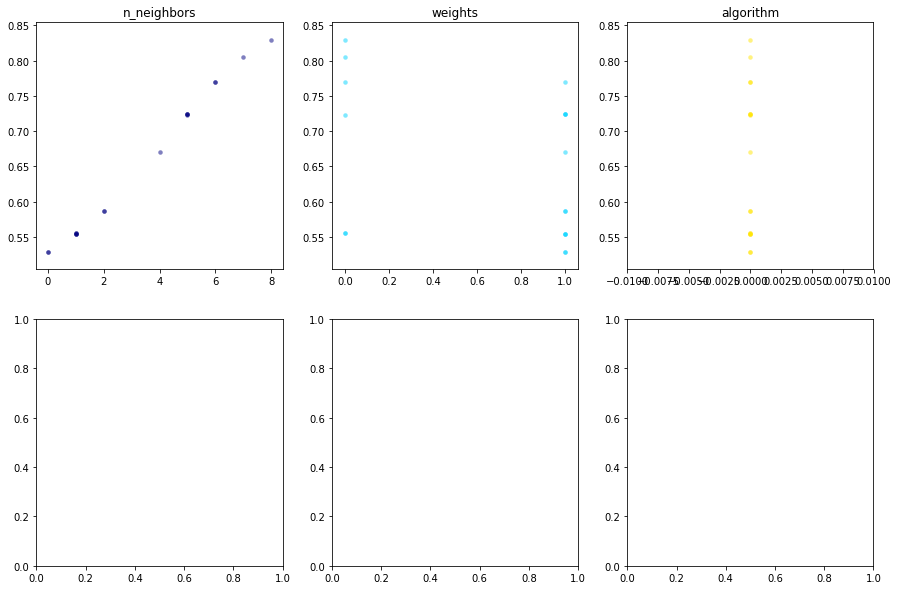

In [14]:
parameters = ['n_neighbors', 'weights', 'algorithm']

f, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,10))
cmap = plt.cm.jet

for i, val in enumerate(parameters):
    print (i, val)
    xs = np.array([t['misc']['vals'][val] for t in trials2.trials]).ravel()
    ys = [-t['result']['loss'] for t in trials2.trials]
    xs, ys = zip(*sorted(zip(xs, ys)))
    ys = np.array(ys)
    axes[i//3,i%3].scatter(xs, ys, s=20, linewidth=0.01, alpha=0.5, c=cmap(float(i)/len(parameters)))
    axes[i//3,i%3].set_title(val)
    #axes[i/3,i%3].set_ylim([0.9,1.0])

### Logistic regression

In [16]:
from sklearn.linear_model import LogisticRegression

In [90]:
best3 = 0

def hyperopt_train_test3(params):
    clf = LogisticRegression(**params)
    return cross_val_score(clf, lgb_train, y,scoring='roc_auc', cv=3, n_jobs=-1).mean()

def loss3(params):
    global best3
    roc = hyperopt_train_test3(params)
    if roc > best3:
        best3 = roc
        print ('new best:', best3, params)
    return {'loss': -roc, 'status': STATUS_OK}

trials3 = Trials()

In [89]:
space4lr = {
    'C': hp.lognormal('C', 0, 5),
    'class_weight': hp.choice('class_weight ', [None, 'balanced']),
    'penalty': hp.choice('penalty', ['l1']),
    'solver': hp.choice('solver',['saga','liblinear'])
}

In [96]:
oof=np.zeros(len(lgb_train))
n_splits = 5 # Number of K-fold Splits
splits = list(StratifiedKFold(n_splits=n_splits, shuffle=True,random_state=1111).split(lgb_train, y))
for i, (train_idx, valid_idx) in enumerate(splits):
    clf=LogisticRegression(C=0.000602399041, class_weight=None, penalty='l1',solver='saga')
    x_trn=np.array(lgb_train)[train_idx]
    y_trn=np.array(y)[train_idx]
    clf.fit(x_trn,y_trn)
    x_val=np.array(lgb_train)[valid_idx]
    oof[valid_idx]=clf.predict_proba(x_val)[:,1]
print (roc_auc_score(y, oof))   

0.901549951457467


In [106]:
clf.coef_

array([[2.75677778, 0.21202559, 0.        , 0.        , 0.49735836,
        0.49735836, 0.34619125]])

In [82]:
lgb_train.head()

,lgb_rank,xgb_rank,et_rank,rf_rank,nb_rank,knn_rank,nn_rank
0,0.172765,0.16339,0.224845,0.262845,0.240780,0.240780,0.197350
1,0.932675,0.91672,0.960690,0.943895,0.929245,0.929245,0.958160
2,0.105860,0.07826,0.292580,0.079755,0.115795,0.115795,0.137145
3,0.893975,0.90369,0.891025,0.843835,0.899970,0.899970,0.878670
4,0.743020,0.82797,0.720895,0.730730,0.748295,0.748295,0.713790


In [91]:
best_cv3 = fmin(loss3, space4lr, algo=tpe.suggest, max_evals=50, trials=trials3)

new best:                                                                                                              
0.5                                                                                                                    
{'C': 2.0559144250889053e-05, 'class_weight': None, 'penalty': 'l1', 'solver': 'saga'}                                 
new best:                                                                                                              
0.9014854003330851                                                                                                     
{'C': 0.06634008745470066, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'liblinear'}                         
new best:                                                                                                              
0.901486522952677                                                                                                      
{'C': 0.05164958658336488, 'class_weight

0 C
1 class_weight 
2 penalty


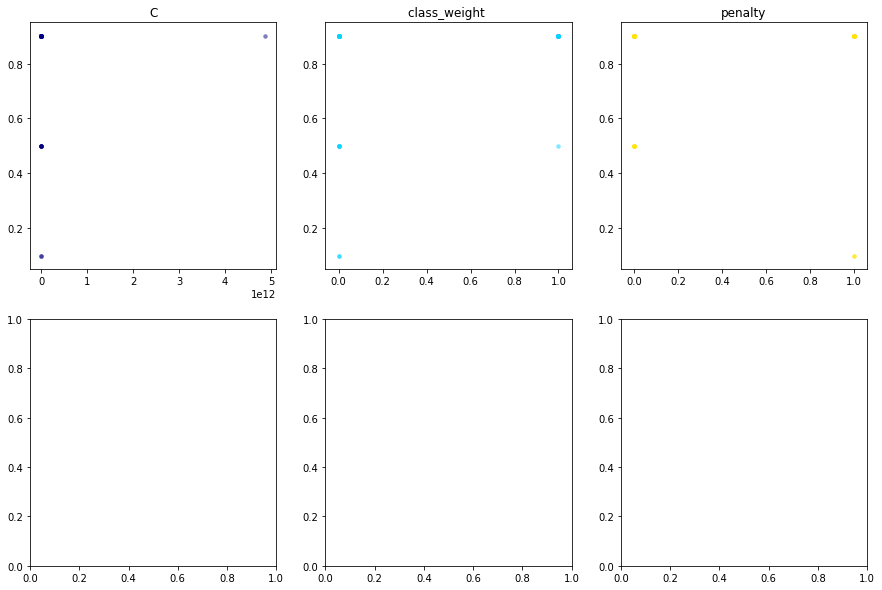

In [59]:
parameters = ['C', 'class_weight ', 'penalty']

f, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,10))
cmap = plt.cm.jet

for i, val in enumerate(parameters):
    print (i, val)
    xs = np.array([t['misc']['vals'][val] for t in trials3.trials]).ravel()
    ys = [-t['result']['loss'] for t in trials3.trials]
    xs, ys = zip(*sorted(zip(xs, ys)))
    ys = np.array(ys)
    axes[i//3,i%3].scatter(xs, ys, s=20, linewidth=0.01, alpha=0.5, c=cmap(float(i)/len(parameters)))
    axes[i//3,i%3].set_title(val)
    #axes[i/3,i%3].set_ylim([0.9,1.0])

### Support vector machine

In [6]:
from sklearn.svm import SVC

In [7]:
best4 = 0

def hyperopt_train_test4(params):
    clf = SVC(**params)
    return cross_val_score(clf, X_small, y_small,scoring='roc_auc', cv=3, n_jobs=-1).mean()

def loss4(params):
    global best4
    roc = hyperopt_train_test4(params)
    if roc > best4:
        best4 = roc
        print ('new best:', best4, params)
    return {'loss': -roc, 'status': STATUS_OK}

trials4 = Trials()

In [8]:
space4svc = {
    'C': hp.lognormal('C', 0, 3),
    'kernel': hp.choice('kernel ', ['rbf', 'poly','sigmoid']),
    'gamma': hp.lognormal('gamma', 0, 3),
    'class_weight': hp.choice('class_weight', ['balanced']),
     'degree': hp.choice('degree', [1,2,3])
}

In [ ]:
best_cv4 = fmin(loss4, space4svc, algo=tpe.suggest, max_evals=100, trials=trials4)

new best:                                                                                                              
0.5                                                                                                                    
{'C': 0.31894451155462056, 'class_weight': 'balanced', 'degree': 2, 'gamma': 0.6399732463927398, 'kernel': 'rbf'}      
  1%|▌                                                           | 1/100 [30:16<49:56:32, 1816.08s/it, best loss: -0.5]

In [69]:
blend_train=pd.read_csv('data/oof_train.csv')

In [72]:
#blend_train['knn6000']=oof
blend_train.describe()

,lgb,xgb,et,rf,nb,knn1024,knn2048,knn4096,knn6000,nn,lgb_rank,xgb_rank,et_rank,rf_rank,nb_rank,knn_rank,nn_rank
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.124640,0.031736,0.141378,0.462142,0.532505,0.035991,0.038355,0.041225,0.117915,0.097595,0.500003,0.500003,0.500002,0.500002,0.500003,0.500003,0.500002
std,0.187732,0.095804,0.014480,0.029265,6.822721,0.012571,0.011733,0.011122,0.026835,0.179971,0.288676,0.288676,0.288676,0.288676,0.288676,0.288676,0.288676
min,0.000058,0.000011,0.093032,0.362467,0.000252,0.003906,0.006836,0.011719,0.041833,0.000041,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005
25%,0.016327,0.001674,0.131309,0.441959,0.020133,0.027344,0.030273,0.033447,0.099000,0.007760,0.250004,0.250004,0.250004,0.250004,0.250004,0.250004,0.250003
50%,0.046639,0.004947,0.140074,0.460285,0.054885,0.034180,0.036621,0.039795,0.114667,0.024959,0.500003,0.500003,0.500003,0.500003,0.500003,0.500003,0.500003
75%,0.138815,0.016842,0.149925,0.480155,0.170041,0.042969,0.044434,0.047363,0.133000,0.088483,0.750001,0.750001,0.750001,0.750001,0.750001,0.750001,0.750001
max,0.999042,0.998312,0.235257,0.601022,1309.814299,0.145508,0.145508,0.132080,0.310500,0.999800,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Blend models by weighted ranks

In [12]:
blend_train.to_csv('data/oof_train.csv', index=False)

In [71]:
blend_train['lgb_rank']=blend_train['lgb'].rank()/200000
blend_train['xgb_rank']=blend_train['xgb'].rank()/200000
blend_train['et_rank']=blend_train['et'].rank()/200000
blend_train['rf_rank']=blend_train['rf'].rank()/200000
blend_train['nb_rank']=blend_train['nb'].rank()/200000
blend_train['knn_rank']=blend_train['nb'].rank()/200000
blend_train['nn_rank']=blend_train['nn'].rank()/200000

In [98]:
blend_test=pd.read_csv("data/test_pred_layer_1.csv")

In [19]:
blend_test.to_csv("data/test_pred_layer_1.csv", index=False)

In [99]:
blend_test.describe()

,lgb,xgb,et,rf,nb,knn1024,nn
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.117297,0.031305,0.141387,0.462227,0.371291,0.179273,0.089385
std,0.168099,0.092649,0.013492,0.027314,4.218662,0.057996,0.158665
min,0.000091,0.000017,0.092282,0.351221,0.000192,0.026367,0.000045
25%,0.017927,0.002217,0.132016,0.443465,0.021935,0.137695,0.008643
50%,0.049635,0.006380,0.140487,0.461118,0.058387,0.171875,0.026801
75%,0.138098,0.020196,0.149694,0.479714,0.168124,0.210938,0.087415
max,0.998715,1.197919,0.221672,0.598871,853.745483,0.768555,0.999634


In [103]:
blend_test['lgb_rank']=blend_test['lgb'].rank()/200000
blend_test['xgb_rank']=blend_test['xgb'].rank()/200000
blend_test['et_rank']=blend_test['et'].rank()/200000
blend_test['rf_rank']=blend_test['rf'].rank()/200000
blend_test['nb_rank']=blend_test['nb'].rank()/200000
#blend_test['knn_rank']=blend_test['knn'].rank()/200000
blend_test['nn_rank']=blend_test['nn'].rank()/200000

In [25]:
df=pd.read_csv('data/test.csv')

In [35]:
df1=pd.read_csv('test/901.csv')

In [37]:
df1['rank']=df1['target'].rank()/200000

In [38]:
df1.head()

,ID_code,target,rank
0,test_0,0.142333,0.756220
1,test_1,0.274733,0.877320
2,test_2,0.241985,0.857165
3,test_3,0.291388,0.886205
4,test_4,0.058313,0.540390


In [39]:
submission=pd.DataFrame()
submission['ID_code']=df['ID_code']
submission['target']=df1['rank']*10+blend_test['nb_rank']

In [40]:
submission.to_csv('submission/ensemble_aver3.csv',index=False)

In [105]:
lgb_train=blend_train[['lgb_rank','xgb_rank','et_rank','rf_rank','nb_rank','nn_rank']]
lgb_train.head()

,lgb_rank,xgb_rank,et_rank,rf_rank,nb_rank,nn_rank
0,0.172765,0.16339,0.224845,0.262845,0.240780,0.197350
1,0.932675,0.91672,0.960690,0.943895,0.929245,0.958160
2,0.105860,0.07826,0.292580,0.079755,0.115795,0.137145
3,0.893975,0.90369,0.891025,0.843835,0.899970,0.878670
4,0.743020,0.82797,0.720895,0.730730,0.748295,0.713790


In [81]:
print (roc_auc_score(y,blend_train['lgb_rank']))
print (roc_auc_score(y,blend_train['xgb_rank']))
print (roc_auc_score(y,blend_train['et_rank']))
print (roc_auc_score(y,blend_train['rf_rank']))
print (roc_auc_score(y,blend_train['nb_rank']))

NameError: name 'blend_train' is not defined

In [22]:
import lightgbm as lgb

In [85]:
lgb_param = {
    # This one seems to be better than the lower one
    'bagging_freq': 5,
        'bagging_fraction': 0.335, 
        'boost_from_average':'false',
        'boost': 'gbdt',
        'feature_fraction': 0.041,
        'learning_rate': 0.0083,#0.0083
        'max_depth': -1,  
        'metric':'auc',
        'min_data_in_leaf': 80,
        'min_sum_hessian_in_leaf': 10.0,
        'num_leaves': 13, 
        #'num_threads': 8,
        'tree_learner': 'serial',
        'objective': 'binary', 
        'verbosity': 1,
        "boost_from_average": "false",
        #'is_unbalance':True #new
}

In [84]:
X=X[:100000]
y=y[:100000]

In [86]:
n_splits = 5 # Number of K-fold Splits
splits = list(StratifiedKFold(n_splits=n_splits, shuffle=True,random_state=1111).split(X, y))

### LightGBM

In [98]:
best5 = 0

def hyperopt_train_test5(params):
    global X
    global y
    global splits
    oof=np.zeros(len(X))
    for i, (train_idx, valid_idx) in enumerate(splits):  
        X = np.array(X)
        y = np.array(y)
        x_train = X[train_idx.astype(int)]
        y_train = y[train_idx.astype(int)]
        X_t, y_t = shuffle(x_train, y_train)
        X_t = pd.DataFrame(X_t)
        X_t = X_t.add_prefix('var_')
        X_t=np.array(X_t)
        y_t=np.array(y_t)

        trn_data = lgb.Dataset(X_t, label=y_t)
        val_data = lgb.Dataset(X[valid_idx.astype(int)], label=y[valid_idx.astype(int)])
        watchlist = [(trn_data, 'train'), (val_data, 'valid')]
        lgb_clf = lgb.train(params, trn_data, 500000, valid_sets = [trn_data, val_data], early_stopping_rounds=3000, verbose_eval=1000)
        oof[valid_idx] = lgb_clf.predict(X[valid_idx], num_iteration=lgb_clf.best_iteration)
    
    return roc_auc_score(y, oof)

def loss5(params):
    global best5
    roc = hyperopt_train_test5(params)
    if roc > best5:
        best5 = roc
        print ('new best:', best5, params)
    return {'loss': -roc, 'status': STATUS_OK}

trials5 = Trials()

In [88]:
space4lgb = {
    'bagging_freq': hp.choice('bagging_freq', [2,3,4,5,6,7]),
    'bagging_fraction': hp.uniform('bagging_fraction', 0.1, 0.5),
    'feature_fraction': hp.uniform('feature_fraction', 0.1, 0.4),
    'learning_rate': hp.uniform('learning_rate', 0.002, 0.015),
    'max_depth': hp.choice('max_depth', [-1,2,4,6,8]),
    'metric': hp.choice('metric', ['auc']),
    'min_data_in_leaf': hp.choice('min_data_in_leaf', [50,55,60,65,75,80,85,90]),
    'min_sum_hessian_in_leaf': hp.choice('min_sum_hessian_in_leaf', [5,7,9,11,13,15]),
    'num_leaves': hp.choice('num_leaves',[7,9,11,13,15,17]),
    'tree_learner': hp.choice('tree_learner',['serial']),
    'objective': hp.choice('objective',['binary']),
    'is_unbalance':hp.choice('is_unbalance', [True, False]),
    'boost_from_average':hp.choice("boost_from_average", [True, False]),
    'boost': hp.choice('boost',['gbdt'])
}

In [99]:
best_cv5 = fmin(loss5, space4lgb, algo=tpe.suggest, max_evals=50, trials=trials5)

Training until validation scores don't improve for 3000 rounds.                                                        
[1000]	training's auc: 0.868777	valid_1's auc: 0.85187                                                                 
[2000]	training's auc: 0.89569	valid_1's auc: 0.87515                                                                  
[3000]	training's auc: 0.90895	valid_1's auc: 0.885319                                                                 
[4000]	training's auc: 0.917059	valid_1's auc: 0.891039                                                                
[5000]	training's auc: 0.922734	valid_1's auc: 0.894179                                                                
[6000]	training's auc: 0.927157	valid_1's auc: 0.895705                                                                
[7000]	training's auc: 0.931077	valid_1's auc: 0.89686                                                                 
[8000]	training's auc: 0.934667	valid_1'

[15000]	training's auc: 0.96061	valid_1's auc: 0.895665                                                                
[16000]	training's auc: 0.96256	valid_1's auc: 0.895728                                                                
[17000]	training's auc: 0.964501	valid_1's auc: 0.895654                                                               
[18000]	training's auc: 0.966324	valid_1's auc: 0.895624                                                               
[19000]	training's auc: 0.968022	valid_1's auc: 0.895585                                                               
Early stopping, best iteration is:                                                                                     
[16254]	training's auc: 0.963064	valid_1's auc: 0.89575
new best:                                                                                                              
0.8958419247275111                                                                                      

[9000]	training's auc: 0.934604	valid_1's auc: 0.894555                                                                
[10000]	training's auc: 0.937376	valid_1's auc: 0.895189                                                               
[11000]	training's auc: 0.939907	valid_1's auc: 0.895551                                                               
[12000]	training's auc: 0.94239	valid_1's auc: 0.895738                                                                
[13000]	training's auc: 0.944733	valid_1's auc: 0.895863                                                               
[14000]	training's auc: 0.947057	valid_1's auc: 0.89595                                                                
[15000]	training's auc: 0.949243	valid_1's auc: 0.895945                                                               
[16000]	training's auc: 0.951336	valid_1's auc: 0.895956                                                               
[17000]	training's auc: 0.953352	valid_1

[8000]	training's auc: 0.932309	valid_1's auc: 0.89069                                                                 
[9000]	training's auc: 0.935914	valid_1's auc: 0.89223                                                                 
[10000]	training's auc: 0.93914	valid_1's auc: 0.893185                                                                
[11000]	training's auc: 0.942024	valid_1's auc: 0.893819                                                               
[12000]	training's auc: 0.944704	valid_1's auc: 0.894417                                                               
[13000]	training's auc: 0.947224	valid_1's auc: 0.8949                                                                 
[14000]	training's auc: 0.949631	valid_1's auc: 0.895234                                                               
[15000]	training's auc: 0.951876	valid_1's auc: 0.895407                                                               
[16000]	training's auc: 0.954044	valid_1

[5000]	training's auc: 0.942886	valid_1's auc: 0.895642                                                                
[6000]	training's auc: 0.948418	valid_1's auc: 0.895945                                                                
[7000]	training's auc: 0.953518	valid_1's auc: 0.895949                                                                
[8000]	training's auc: 0.958137	valid_1's auc: 0.895733                                                                
[9000]	training's auc: 0.962487	valid_1's auc: 0.89582                                                                 
Early stopping, best iteration is:                                                                                     
[6788]	training's auc: 0.952447	valid_1's auc: 0.896054
Training until validation scores don't improve for 3000 rounds.                                                        
[1000]	training's auc: 0.906288	valid_1's auc: 0.875511                                                 

[4000]	training's auc: 0.9321	valid_1's auc: 0.886502                                                                  
[5000]	training's auc: 0.938148	valid_1's auc: 0.888667                                                                
[6000]	training's auc: 0.943115	valid_1's auc: 0.889562                                                                
[7000]	training's auc: 0.947676	valid_1's auc: 0.890074                                                                
[8000]	training's auc: 0.951879	valid_1's auc: 0.890399                                                                
[9000]	training's auc: 0.955788	valid_1's auc: 0.890326                                                                
[10000]	training's auc: 0.959511	valid_1's auc: 0.890094                                                               
Early stopping, best iteration is:                                                                                     
[7986]	training's auc: 0.951816	valid_1'

Training until validation scores don't improve for 3000 rounds.                                                        
[1000]	training's auc: 0.849779	valid_1's auc: 0.836149                                                                
[2000]	training's auc: 0.871144	valid_1's auc: 0.854423                                                                
[3000]	training's auc: 0.886721	valid_1's auc: 0.868033                                                                
[4000]	training's auc: 0.896887	valid_1's auc: 0.876553                                                                
[5000]	training's auc: 0.904146	valid_1's auc: 0.88251                                                                 
[6000]	training's auc: 0.909622	valid_1's auc: 0.886691                                                                
[7000]	training's auc: 0.913844	valid_1's auc: 0.889665                                                                
[8000]	training's auc: 0.91719	valid_1's

[22000]	training's auc: 0.933567	valid_1's auc: 0.897506                                                               
[23000]	training's auc: 0.934744	valid_1's auc: 0.897595                                                               
[24000]	training's auc: 0.935892	valid_1's auc: 0.897693                                                               
[25000]	training's auc: 0.937028	valid_1's auc: 0.897807                                                               
[26000]	training's auc: 0.938162	valid_1's auc: 0.89786                                                                
[27000]	training's auc: 0.939274	valid_1's auc: 0.897904                                                               
[28000]	training's auc: 0.940366	valid_1's auc: 0.897933                                                               
[29000]	training's auc: 0.941437	valid_1's auc: 0.89797                                                                
[30000]	training's auc: 0.942491	valid_1

[11000]	training's auc: 0.921128	valid_1's auc: 0.883014                                                               
[12000]	training's auc: 0.923653	valid_1's auc: 0.884611                                                               
[13000]	training's auc: 0.925973	valid_1's auc: 0.88597                                                                
[14000]	training's auc: 0.928021	valid_1's auc: 0.887001                                                               
[15000]	training's auc: 0.929931	valid_1's auc: 0.887881                                                               
[16000]	training's auc: 0.931653	valid_1's auc: 0.888688                                                               
[17000]	training's auc: 0.933243	valid_1's auc: 0.88931                                                                
[18000]	training's auc: 0.934669	valid_1's auc: 0.889782                                                               
[19000]	training's auc: 0.936048	valid_1

[1000]	training's auc: 0.830767	valid_1's auc: 0.807658                                                                
[2000]	training's auc: 0.864549	valid_1's auc: 0.838958                                                                
[3000]	training's auc: 0.883339	valid_1's auc: 0.855472                                                                
[4000]	training's auc: 0.894767	valid_1's auc: 0.86517                                                                 
[5000]	training's auc: 0.902675	valid_1's auc: 0.871533                                                                
[6000]	training's auc: 0.908777	valid_1's auc: 0.876131                                                                
[7000]	training's auc: 0.913583	valid_1's auc: 0.879106                                                                
[8000]	training's auc: 0.917201	valid_1's auc: 0.881762                                                                
[9000]	training's auc: 0.9203	valid_1's 

[19000]	training's auc: 0.920929	valid_1's auc: 0.894085                                                               
[20000]	training's auc: 0.922101	valid_1's auc: 0.894629                                                               
[21000]	training's auc: 0.923153	valid_1's auc: 0.895028                                                               
[22000]	training's auc: 0.924178	valid_1's auc: 0.895456                                                               
[23000]	training's auc: 0.925151	valid_1's auc: 0.89578                                                                
[24000]	training's auc: 0.926056	valid_1's auc: 0.895994                                                               
[25000]	training's auc: 0.926946	valid_1's auc: 0.896236                                                               
[26000]	training's auc: 0.927796	valid_1's auc: 0.89639                                                                
[27000]	training's auc: 0.928626	valid_1

[34000]	training's auc: 0.935609	valid_1's auc: 0.894826                                                               
[35000]	training's auc: 0.936275	valid_1's auc: 0.894823                                                               
[36000]	training's auc: 0.936883	valid_1's auc: 0.894868                                                               
[37000]	training's auc: 0.937531	valid_1's auc: 0.89491                                                                
[38000]	training's auc: 0.938154	valid_1's auc: 0.894918                                                               
[39000]	training's auc: 0.938781	valid_1's auc: 0.894918                                                               
[40000]	training's auc: 0.939397	valid_1's auc: 0.894866                                                               
[41000]	training's auc: 0.94002	valid_1's auc: 0.894799                                                                
Early stopping, best iteration is:      

[14000]	training's auc: 0.922309	valid_1's auc: 0.889621                                                               
[15000]	training's auc: 0.924091	valid_1's auc: 0.890723                                                               
[16000]	training's auc: 0.925685	valid_1's auc: 0.891593                                                               
[17000]	training's auc: 0.927144	valid_1's auc: 0.892341                                                               
[18000]	training's auc: 0.928545	valid_1's auc: 0.893006                                                               
[19000]	training's auc: 0.929864	valid_1's auc: 0.893605                                                               
[20000]	training's auc: 0.931086	valid_1's auc: 0.894021                                                               
[21000]	training's auc: 0.932235	valid_1's auc: 0.894403                                                               
[22000]	training's auc: 0.93333	valid_1'

[5000]	training's auc: 0.953281	valid_1's auc: 0.898069                                                                
[6000]	training's auc: 0.959973	valid_1's auc: 0.897882                                                                
[7000]	training's auc: 0.965881	valid_1's auc: 0.897966                                                                
[8000]	training's auc: 0.971241	valid_1's auc: 0.897466                                                                
Early stopping, best iteration is:                                                                                     
[5395]	training's auc: 0.956006	valid_1's auc: 0.898351
Training until validation scores don't improve for 3000 rounds.                                                        
[1000]	training's auc: 0.906026	valid_1's auc: 0.87524                                                                 
[2000]	training's auc: 0.928253	valid_1's auc: 0.889305                                                 

Training until validation scores don't improve for 3000 rounds.                                                        
[1000]	training's auc: 0.889229	valid_1's auc: 0.866074                                                                
[2000]	training's auc: 0.914301	valid_1's auc: 0.886695                                                                
[3000]	training's auc: 0.925227	valid_1's auc: 0.893641                                                                
[4000]	training's auc: 0.931903	valid_1's auc: 0.896613                                                                
[5000]	training's auc: 0.936642	valid_1's auc: 0.897867                                                                
[6000]	training's auc: 0.941234	valid_1's auc: 0.898485                                                                
[7000]	training's auc: 0.945439	valid_1's auc: 0.898482                                                                
[8000]	training's auc: 0.949488	valid_1'

[9000]	training's auc: 0.915012	valid_1's auc: 0.88418                                                                 
[10000]	training's auc: 0.91821	valid_1's auc: 0.886519                                                                
[11000]	training's auc: 0.921017	valid_1's auc: 0.888226                                                               
[12000]	training's auc: 0.923446	valid_1's auc: 0.889635                                                               
[13000]	training's auc: 0.925637	valid_1's auc: 0.890834                                                               
[14000]	training's auc: 0.927643	valid_1's auc: 0.891832                                                               
[15000]	training's auc: 0.929425	valid_1's auc: 0.892651                                                               
[16000]	training's auc: 0.931022	valid_1's auc: 0.893336                                                               
[17000]	training's auc: 0.932559	valid_1

[13000]	training's auc: 0.927386	valid_1's auc: 0.89063                                                                
[14000]	training's auc: 0.928689	valid_1's auc: 0.890808                                                               
[15000]	training's auc: 0.929934	valid_1's auc: 0.89088                                                                
[16000]	training's auc: 0.931097	valid_1's auc: 0.890898                                                               
[17000]	training's auc: 0.932223	valid_1's auc: 0.890994                                                               
[18000]	training's auc: 0.933358	valid_1's auc: 0.890963                                                               
[19000]	training's auc: 0.934464	valid_1's auc: 0.890899                                                               
[20000]	training's auc: 0.935529	valid_1's auc: 0.890746                                                               
Early stopping, best iteration is:      

[15000]	training's auc: 0.928191	valid_1's auc: 0.898231                                                               
[16000]	training's auc: 0.929629	valid_1's auc: 0.898418                                                               
[17000]	training's auc: 0.93098	valid_1's auc: 0.898448                                                                
[18000]	training's auc: 0.932346	valid_1's auc: 0.898427                                                               
[19000]	training's auc: 0.933671	valid_1's auc: 0.898496                                                               
[20000]	training's auc: 0.934973	valid_1's auc: 0.89843                                                                
[21000]	training's auc: 0.93626	valid_1's auc: 0.898429                                                                
[22000]	training's auc: 0.937497	valid_1's auc: 0.898472                                                               
Early stopping, best iteration is:      

[15000]	training's auc: 0.934779	valid_1's auc: 0.89945                                                                
[16000]	training's auc: 0.936302	valid_1's auc: 0.899316                                                               
Early stopping, best iteration is:                                                                                     
[13583]	training's auc: 0.932585	valid_1's auc: 0.899577
Training until validation scores don't improve for 3000 rounds.                                                        
[1000]	training's auc: 0.855974	valid_1's auc: 0.839204                                                                
[2000]	training's auc: 0.886326	valid_1's auc: 0.866054                                                                
[3000]	training's auc: 0.9004	valid_1's auc: 0.877933                                                                  
[4000]	training's auc: 0.908738	valid_1's auc: 0.884559                                                

[2000]	training's auc: 0.919129	valid_1's auc: 0.881046                                                                
[3000]	training's auc: 0.932411	valid_1's auc: 0.889455                                                                
[4000]	training's auc: 0.940723	valid_1's auc: 0.893501                                                                
[5000]	training's auc: 0.94683	valid_1's auc: 0.895447                                                                 
[6000]	training's auc: 0.951756	valid_1's auc: 0.89648                                                                 
[7000]	training's auc: 0.95606	valid_1's auc: 0.897236                                                                 
[8000]	training's auc: 0.960106	valid_1's auc: 0.897363                                                                
[9000]	training's auc: 0.963994	valid_1's auc: 0.897345                                                                
[10000]	training's auc: 0.967502	valid_1

[16000]	training's auc: 0.914839	valid_1's auc: 0.895088                                                               
[17000]	training's auc: 0.916236	valid_1's auc: 0.895807                                                               
[18000]	training's auc: 0.917521	valid_1's auc: 0.896302                                                               
[19000]	training's auc: 0.918741	valid_1's auc: 0.896764                                                               
[20000]	training's auc: 0.919875	valid_1's auc: 0.897164                                                               
[21000]	training's auc: 0.920953	valid_1's auc: 0.897476                                                               
[22000]	training's auc: 0.921993	valid_1's auc: 0.897741                                                               
[23000]	training's auc: 0.923028	valid_1's auc: 0.897968                                                               
[24000]	training's auc: 0.924011	valid_1

[24000]	training's auc: 0.926195	valid_1's auc: 0.895147                                                               
[25000]	training's auc: 0.927097	valid_1's auc: 0.895305                                                               
[26000]	training's auc: 0.927988	valid_1's auc: 0.895445                                                               
[27000]	training's auc: 0.928855	valid_1's auc: 0.895567                                                               
[28000]	training's auc: 0.929686	valid_1's auc: 0.895787                                                               
[29000]	training's auc: 0.930516	valid_1's auc: 0.895923                                                               
[30000]	training's auc: 0.931318	valid_1's auc: 0.896047                                                               
[31000]	training's auc: 0.932112	valid_1's auc: 0.896084                                                               
[32000]	training's auc: 0.932889	valid_1

[9000]	training's auc: 0.926996	valid_1's auc: 0.895879                                                                
[10000]	training's auc: 0.929524	valid_1's auc: 0.896602                                                               
[11000]	training's auc: 0.931926	valid_1's auc: 0.897283                                                               
[12000]	training's auc: 0.934268	valid_1's auc: 0.897828                                                               
[13000]	training's auc: 0.936518	valid_1's auc: 0.898248                                                               
[14000]	training's auc: 0.938671	valid_1's auc: 0.898551                                                               
[15000]	training's auc: 0.940813	valid_1's auc: 0.898719                                                               
[16000]	training's auc: 0.942898	valid_1's auc: 0.898816                                                               
[17000]	training's auc: 0.944912	valid_1

[8000]	training's auc: 0.913783	valid_1's auc: 0.895989                                                                
[9000]	training's auc: 0.91583	valid_1's auc: 0.897259                                                                 
[10000]	training's auc: 0.917612	valid_1's auc: 0.898074                                                               
[11000]	training's auc: 0.919134	valid_1's auc: 0.898548                                                               
[12000]	training's auc: 0.920538	valid_1's auc: 0.898931                                                               
[13000]	training's auc: 0.921792	valid_1's auc: 0.899345                                                               
[14000]	training's auc: 0.922941	valid_1's auc: 0.899744                                                               
[15000]	training's auc: 0.924091	valid_1's auc: 0.899751                                                               
[16000]	training's auc: 0.925167	valid_1

[22000]	training's auc: 0.917828	valid_1's auc: 0.896656                                                               
[23000]	training's auc: 0.918607	valid_1's auc: 0.897083                                                               
[24000]	training's auc: 0.919357	valid_1's auc: 0.897524                                                               
[25000]	training's auc: 0.92003	valid_1's auc: 0.897816                                                                
[26000]	training's auc: 0.920716	valid_1's auc: 0.898094                                                               
[27000]	training's auc: 0.92136	valid_1's auc: 0.898367                                                                
[28000]	training's auc: 0.921974	valid_1's auc: 0.898546                                                               
[29000]	training's auc: 0.922548	valid_1's auc: 0.898737                                                               
[30000]	training's auc: 0.9231	valid_1's

[19000]	training's auc: 0.918698	valid_1's auc: 0.888763                                                               
[20000]	training's auc: 0.919686	valid_1's auc: 0.889359                                                               
[21000]	training's auc: 0.920591	valid_1's auc: 0.889811                                                               
[22000]	training's auc: 0.921406	valid_1's auc: 0.890129                                                               
[23000]	training's auc: 0.922217	valid_1's auc: 0.890415                                                               
[24000]	training's auc: 0.922951	valid_1's auc: 0.890703                                                               
[25000]	training's auc: 0.923643	valid_1's auc: 0.890932                                                               
[26000]	training's auc: 0.924352	valid_1's auc: 0.891154                                                               
[27000]	training's auc: 0.925013	valid_1

[19000]	training's auc: 0.915455	valid_1's auc: 0.894532                                                               
[20000]	training's auc: 0.916553	valid_1's auc: 0.895256                                                               
[21000]	training's auc: 0.917535	valid_1's auc: 0.89577                                                                
[22000]	training's auc: 0.918474	valid_1's auc: 0.896203                                                               
[23000]	training's auc: 0.919349	valid_1's auc: 0.89667                                                                
[24000]	training's auc: 0.920161	valid_1's auc: 0.89706                                                                
[25000]	training's auc: 0.92093	valid_1's auc: 0.897315                                                                
[26000]	training's auc: 0.921638	valid_1's auc: 0.897573                                                               
[27000]	training's auc: 0.922369	valid_1

[24000]	training's auc: 0.922546	valid_1's auc: 0.894062                                                               
[25000]	training's auc: 0.923304	valid_1's auc: 0.894382                                                               
[26000]	training's auc: 0.924042	valid_1's auc: 0.894675                                                               
[27000]	training's auc: 0.924705	valid_1's auc: 0.894802                                                               
[28000]	training's auc: 0.925355	valid_1's auc: 0.895052                                                               
[29000]	training's auc: 0.925983	valid_1's auc: 0.895235                                                               
[30000]	training's auc: 0.926639	valid_1's auc: 0.895449                                                               
[31000]	training's auc: 0.927249	valid_1's auc: 0.895556                                                               
[32000]	training's auc: 0.927874	valid_1

[39000]	training's auc: 0.931228	valid_1's auc: 0.897802                                                               
[40000]	training's auc: 0.931803	valid_1's auc: 0.897815                                                               
[41000]	training's auc: 0.932362	valid_1's auc: 0.89785                                                                
[42000]	training's auc: 0.932906	valid_1's auc: 0.897875                                                               
[43000]	training's auc: 0.933462	valid_1's auc: 0.897879                                                               
[44000]	training's auc: 0.934019	valid_1's auc: 0.897825                                                               
Early stopping, best iteration is:                                                                                     
[41590]	training's auc: 0.932691	valid_1's auc: 0.897896
Training until validation scores don't improve for 3000 rounds.                                        

[23000]	training's auc: 0.925245	valid_1's auc: 0.899126                                                               
[24000]	training's auc: 0.926022	valid_1's auc: 0.899267                                                               
[25000]	training's auc: 0.926752	valid_1's auc: 0.899392                                                               
[26000]	training's auc: 0.927512	valid_1's auc: 0.899461                                                               
[27000]	training's auc: 0.928203	valid_1's auc: 0.899503                                                               
[28000]	training's auc: 0.928883	valid_1's auc: 0.899439                                                               
[29000]	training's auc: 0.929542	valid_1's auc: 0.899436                                                               
Early stopping, best iteration is:                                                                                     
[26666]	training's auc: 0.927987	valid_1

[25000]	training's auc: 0.915495	valid_1's auc: 0.883575                                                               
[26000]	training's auc: 0.916487	valid_1's auc: 0.884209                                                               
[27000]	training's auc: 0.917446	valid_1's auc: 0.88481                                                                
[28000]	training's auc: 0.918243	valid_1's auc: 0.885269                                                               
[29000]	training's auc: 0.919044	valid_1's auc: 0.885737                                                               
[30000]	training's auc: 0.919807	valid_1's auc: 0.8862                                                                 
[31000]	training's auc: 0.920538	valid_1's auc: 0.88653                                                                
[32000]	training's auc: 0.921234	valid_1's auc: 0.886916                                                               
[33000]	training's auc: 0.92192	valid_1'

[21000]	training's auc: 0.909162	valid_1's auc: 0.883975                                                               
[22000]	training's auc: 0.910416	valid_1's auc: 0.884862                                                               
[23000]	training's auc: 0.911588	valid_1's auc: 0.885644                                                               
[24000]	training's auc: 0.912715	valid_1's auc: 0.8864                                                                 
[25000]	training's auc: 0.913741	valid_1's auc: 0.887095                                                               
[26000]	training's auc: 0.914702	valid_1's auc: 0.887742                                                               
[27000]	training's auc: 0.915661	valid_1's auc: 0.888366                                                               
[28000]	training's auc: 0.916551	valid_1's auc: 0.888848                                                               
[29000]	training's auc: 0.917398	valid_1

[8000]	training's auc: 0.8977	valid_1's auc: 0.87832                                                                   
[9000]	training's auc: 0.901503	valid_1's auc: 0.88158                                                                 
[10000]	training's auc: 0.904475	valid_1's auc: 0.884202                                                               
[11000]	training's auc: 0.907196	valid_1's auc: 0.886542                                                               
[12000]	training's auc: 0.909432	valid_1's auc: 0.888251                                                               
[13000]	training's auc: 0.911409	valid_1's auc: 0.889707                                                               
[14000]	training's auc: 0.913141	valid_1's auc: 0.891099                                                               
[15000]	training's auc: 0.914732	valid_1's auc: 0.892277                                                               
[16000]	training's auc: 0.916157	valid_1

[20000]	training's auc: 0.925294	valid_1's auc: 0.889917                                                               
[21000]	training's auc: 0.926231	valid_1's auc: 0.890138                                                               
[22000]	training's auc: 0.927156	valid_1's auc: 0.890233                                                               
[23000]	training's auc: 0.928023	valid_1's auc: 0.890363                                                               
[24000]	training's auc: 0.928829	valid_1's auc: 0.890575                                                               
[25000]	training's auc: 0.92961	valid_1's auc: 0.890643                                                                
[26000]	training's auc: 0.930364	valid_1's auc: 0.890728                                                               
[27000]	training's auc: 0.931098	valid_1's auc: 0.89078                                                                
[28000]	training's auc: 0.931799	valid_1

[46000]	training's auc: 0.924206	valid_1's auc: 0.898895                                                               
[47000]	training's auc: 0.924583	valid_1's auc: 0.898937                                                               
[48000]	training's auc: 0.924933	valid_1's auc: 0.898981                                                               
[49000]	training's auc: 0.925299	valid_1's auc: 0.899048                                                               
[50000]	training's auc: 0.925675	valid_1's auc: 0.899084                                                               
[51000]	training's auc: 0.926008	valid_1's auc: 0.899076                                                               
[52000]	training's auc: 0.926384	valid_1's auc: 0.899082                                                               
[53000]	training's auc: 0.926751	valid_1's auc: 0.899128                                                               
[54000]	training's auc: 0.927101	valid_1

[2000]	training's auc: 0.822053	valid_1's auc: 0.810039                                                                
[3000]	training's auc: 0.84036	valid_1's auc: 0.826188                                                                 
[4000]	training's auc: 0.852963	valid_1's auc: 0.83769                                                                 
[5000]	training's auc: 0.862164	valid_1's auc: 0.845965                                                                
[6000]	training's auc: 0.86973	valid_1's auc: 0.852882                                                                 
[7000]	training's auc: 0.875673	valid_1's auc: 0.858132                                                                
[8000]	training's auc: 0.880847	valid_1's auc: 0.862656                                                                
[9000]	training's auc: 0.885148	valid_1's auc: 0.866474                                                                
[10000]	training's auc: 0.888724	valid_1

0 bagging_freq
1 bagging_fraction
2 feature_fraction
3 learning_rate
4 max_depth
5 metric
6 min_data_in_leaf
7 min_sum_hessian_in_leaf
8 num_leaves
9 tree_learner
10 objective
11 is_unbalance
12 boost_from_average
13 boost


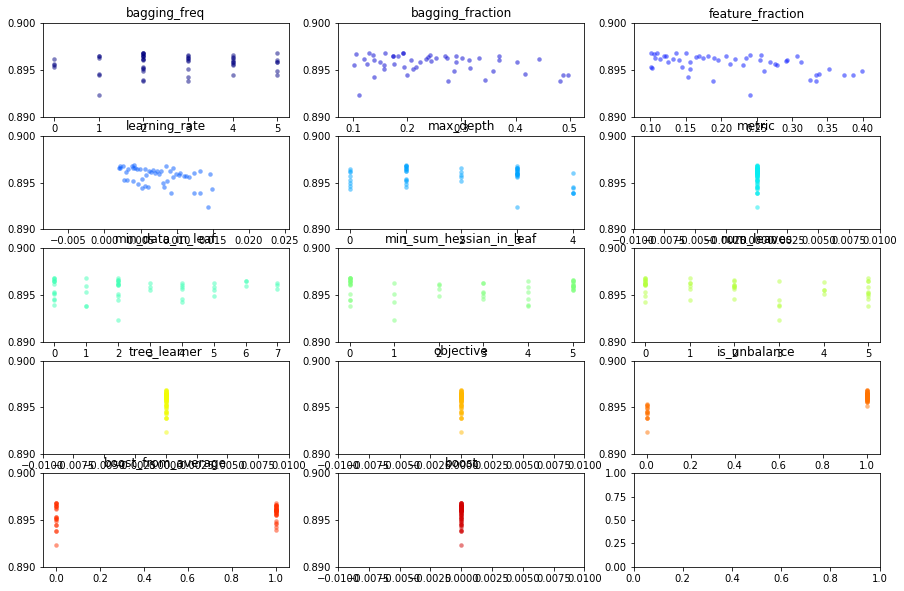

In [111]:
parameters = ['bagging_freq', 'bagging_fraction', 'feature_fraction','learning_rate','max_depth','metric','min_data_in_leaf',
             'min_sum_hessian_in_leaf','num_leaves','tree_learner','objective','is_unbalance','boost_from_average','boost']

f, axes = plt.subplots(nrows=5, ncols=3, figsize=(15,10))
cmap = plt.cm.jet

for i, val in enumerate(parameters):
    print (i, val)
    xs = np.array([t['misc']['vals'][val] for t in trials5.trials]).ravel()
    ys = [-t['result']['loss'] for t in trials5.trials]
    xs, ys = zip(*sorted(zip(xs, ys)))
    ys = np.array(ys)
    axes[i//3,i%3].scatter(xs, ys, s=20, linewidth=0.01, alpha=0.5, c=cmap(float(i)/len(parameters)))
    axes[i//3,i%3].set_title(val)
    axes[i//3,i%3].set_ylim([0.89,0.9])

In [60]:
n_splits = 5 # Number of K-fold Splits
splits = list(StratifiedKFold(n_splits=n_splits, shuffle=True,random_state=1111).split(lgb_train, y))

In [62]:
lgb_param = {
    # This one seems to be better than the lower one
    #'bagging_freq': 5,
        #'bagging_fraction': 0.4, 
        #'boost_from_average':'false',
        'boost': 'gbdt',
        #'feature_fraction': 0.8,
        'learning_rate': 0.002,#0.0083
        'max_depth': -1,  
        'metric':'auc',
        #'min_data_in_leaf': 80,
        #'min_sum_hessian_in_leaf': 10.0,
        #'num_leaves': 13, 
        #'num_threads': 8,
        'tree_learner': 'serial',
        'objective': 'binary', 
        'verbosity': 1,
        #"boost_from_average": "false",
        #'is_unbalance':True #new
}

In [63]:
lgb_oof=np.zeros(len(lgb_train))
feature_importance_df = pd.DataFrame()
for fold, (train_idx, valid_idx) in enumerate(splits):  
        X = np.array(lgb_train)
        y = np.array(y)
        X_train = X[train_idx.astype(int)]
        y_train = y[train_idx.astype(int)]
    
        trn_data = lgb.Dataset(X_train, label=y_train)
        val_data = lgb.Dataset(X[valid_idx.astype(int)], label=y[valid_idx.astype(int)])
        watchlist = [(trn_data, 'train'), (val_data, 'valid')]
        lgb_clf = lgb.train(lgb_param,trn_data, 10000, valid_sets = [trn_data, val_data], early_stopping_rounds=1000, verbose_eval=500)
        lgb_oof[valid_idx] = lgb_clf.predict(X[valid_idx], num_iteration=lgb_clf.best_iteration)
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = lgb_train.columns
        fold_importance_df["importance"] = lgb_clf.feature_importance()
        fold_importance_df["fold"] = fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
print (roc_auc_score(y, lgb_oof))

Training until validation scores don't improve for 1000 rounds.
[500]	training's auc: 0.904038	valid_1's auc: 0.897279
[1000]	training's auc: 0.905373	valid_1's auc: 0.89723
Early stopping, best iteration is:
[393]	training's auc: 0.903791	valid_1's auc: 0.897316
Training until validation scores don't improve for 1000 rounds.
[500]	training's auc: 0.90373	valid_1's auc: 0.898415
[1000]	training's auc: 0.904943	valid_1's auc: 0.898604
[1500]	training's auc: 0.9068	valid_1's auc: 0.898636
[2000]	training's auc: 0.908919	valid_1's auc: 0.898606
[2500]	training's auc: 0.910807	valid_1's auc: 0.89853
Early stopping, best iteration is:
[1583]	training's auc: 0.90714	valid_1's auc: 0.898675
Training until validation scores don't improve for 1000 rounds.
[500]	training's auc: 0.902642	valid_1's auc: 0.90247
[1000]	training's auc: 0.903932	valid_1's auc: 0.902559
[1500]	training's auc: 0.905553	valid_1's auc: 0.902487
Early stopping, best iteration is:
[830]	training's auc: 0.903433	valid_1's a

In [64]:
feature_importance_df.groupby('feature')['importance'].describe()

,count,mean,std,min,25%,50%,75%,max
feature,,,,,,,,
et_rank,5.0,3626.4,2281.750052,966.0,2248.0,2961.0,5566.0,6391.0
knn_rank,5.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
lgb_rank,5.0,6959.2,3002.207305,3440.0,5607.0,6014.0,8448.0,11287.0
nb_rank,5.0,6091.6,2490.874806,2722.0,4907.0,5892.0,7868.0,9069.0
nn_rank,5.0,4536.0,2084.851673,1605.0,3851.0,4118.0,6466.0,6640.0
rf_rank,5.0,3324.4,2093.047611,938.0,1985.0,2774.0,4920.0,6005.0
xgb_rank,5.0,5480.4,2553.171224,2119.0,4121.0,5142.0,7922.0,8098.0


In [68]:
average=blend_train['lgb_rank']*3+blend_train['xgb_rank']*2.5+blend_train['nb_rank']*2.5+blend_train['nn_rank']*1.5+blend_train['et_rank']*0.9
roc_auc_score(y,average)                                                                                                                                  

0.9013089524435733